In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


warnings.filterwarnings("ignore", message="No frequency information was provided.*")

In [2]:
# processed_cluster_data_diff = pd.read_csv('processed_cluster_data_diff.csv')

In [3]:
processed_cluster_data_diff = pd.read_csv('processed_cluster_data_diff.csv')

In [4]:
processed_cluster_data_diff = processed_cluster_data_diff.drop('Unnamed: 0', axis=1)

In [5]:
processed_cluster_data_diff

time  precipitation_diff  location_cluster  year  month  day  \
0    1949-01-31            0.401841                 2  1949      1   31   
1    1949-04-30            1.094839                 2  1949      4   30   
2    1949-07-31            0.355535                 2  1949      7   31   
3    1949-10-31            0.641876                 2  1949     10   31   
4    1950-01-31            1.777431                 2  1950      1   31   
..          ...                 ...               ...   ...    ...  ...   
550  1994-01-31            1.504442                 0  1994      1   31   
551  1994-04-30            1.494714                 0  1994      4   30   
552  1994-07-31            0.512250                 0  1994      7   31   
553  1994-10-31            0.654943                 0  1994     10   31   
554  1995-01-31            2.749879                 0  1995      1   31   

     week_of_year  day_of_week  day_of_year  quarter  season  month_cos  \
0               5            0           31        1  Winter   0.866025   
1              17            5          120        2  Spring  -0.500000   
2              30            6          212        3  Summer  -0.866025   
3              44            0          304        4    Fall   0.500000   
4               5            1           31        1  Winter   0.866025   
..            ...          ...          ...      ...     ...        ...   
550             5            0           31        1  Winter   0.866025   
551            17            5          120        2  Spring  -0.500000   
552            30            6          212        3  Summer  -0.866025   
553            44            0          304        4    Fall   0.500000   
554             5            1           31        1  Winter   0.866025   

     day_of_week_cos  
0           1.000000  
1          -0.222521  
2           0.623490  
3           1.000000  
4           0.623490  
..               ...  
550         1.000000  
551        -0.222521  
552         0.623490  
553         1.000000  
554         0.623490  

[555 rows x 13 columns]

In [6]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# processed_cluster_data_diff['precipitation_diff'] = scaler.fit_transform(processed_cluster_data_diff[['precipitation_diff']])

In [7]:
# from sklearn.preprocessing import RobustScaler
# robust_scaler = RobustScaler()
# processed_cluster_data_diff['precipitation_diff'] = robust_scaler.fit_transform(processed_cluster_data_diff[['precipitation_diff']])


In [8]:
processed_cluster_data_diff

time  precipitation_diff  location_cluster  year  month  day  \
0    1949-01-31            0.401841                 2  1949      1   31   
1    1949-04-30            1.094839                 2  1949      4   30   
2    1949-07-31            0.355535                 2  1949      7   31   
3    1949-10-31            0.641876                 2  1949     10   31   
4    1950-01-31            1.777431                 2  1950      1   31   
..          ...                 ...               ...   ...    ...  ...   
550  1994-01-31            1.504442                 0  1994      1   31   
551  1994-04-30            1.494714                 0  1994      4   30   
552  1994-07-31            0.512250                 0  1994      7   31   
553  1994-10-31            0.654943                 0  1994     10   31   
554  1995-01-31            2.749879                 0  1995      1   31   

     week_of_year  day_of_week  day_of_year  quarter  season  month_cos  \
0               5            0           31        1  Winter   0.866025   
1              17            5          120        2  Spring  -0.500000   
2              30            6          212        3  Summer  -0.866025   
3              44            0          304        4    Fall   0.500000   
4               5            1           31        1  Winter   0.866025   
..            ...          ...          ...      ...     ...        ...   
550             5            0           31        1  Winter   0.866025   
551            17            5          120        2  Spring  -0.500000   
552            30            6          212        3  Summer  -0.866025   
553            44            0          304        4    Fall   0.500000   
554             5            1           31        1  Winter   0.866025   

     day_of_week_cos  
0           1.000000  
1          -0.222521  
2           0.623490  
3           1.000000  
4           0.623490  
..               ...  
550         1.000000  
551        -0.222521  
552         0.623490  
553         1.000000  
554         0.623490  

[555 rows x 13 columns]

## Baseline Model

In [9]:
baseline_df = processed_cluster_data_diff.copy()

In [10]:
target = 'precipitation_diff' if 'precipitation_diff' in baseline_df.columns else 'precipitation'

for cluster_id in baseline_df['location_cluster'].unique():
    # Filter data for the current cluster
    cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
    
    # Calculate mean and median for the target variable within this cluster
    mean_value = cluster_data[target].mean()
    median_value = cluster_data[target].median()
    
    # Store these baseline predictions back into the DataFrame
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'mean_prediction'] = mean_value
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'median_prediction'] = median_value

if target in baseline_df.columns:
    overall_rmse_mean = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['mean_prediction']))
    overall_rmse_median = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['median_prediction']))
    
    print(f'Overall Mean Predictor RMSE: {overall_rmse_mean}')
    print(f'Overall Median Predictor RMSE: {overall_rmse_median}')

Overall Mean Predictor RMSE: 0.4833937094339008
Overall Median Predictor RMSE: 0.49328851001487634


In [11]:
if target in baseline_df.columns:
    # Calculate RMSE for each cluster and overall
    for cluster_id in baseline_df['location_cluster'].unique():
        cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
        rmse_mean = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['mean_prediction']))
        rmse_median = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['median_prediction']))
        
        print(f'Cluster {cluster_id} - Mean Predictor RMSE: {rmse_mean:.4f}, Median Predictor RMSE: {rmse_median:.4f}')

Cluster 2 - Mean Predictor RMSE: 0.4319, Median Predictor RMSE: 0.4413
Cluster 1 - Mean Predictor RMSE: 0.2110, Median Predictor RMSE: 0.2143
Cluster 0 - Mean Predictor RMSE: 0.6856, Median Predictor RMSE: 0.6995


### Machine Learning Models (Training and Evaluation)

Functions

In [12]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [13]:
def calculate_average_metrics(rmse_values : list, mae_values : list, r2_values : list):
    avg_rmse = np.mean(rmse_values)
    avg_mae = np.mean(mae_values)
    avg_r2 = np.mean(r2_values)
    return avg_rmse, avg_mae, avg_r2

In [14]:
def plot_model_scores(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    
    # Print RMSE
    # print(f'Train Score ({model_name}): {trainScore:.2f} RMSE')
    # print(f'Test Score ({model_name}): {testScore:.2f} RMSE')

    # Plot RMSE
    plt.figure(figsize=(6, 4))
    plt.bar(['Training', 'Testing'], [trainScore, testScore], color=['blue', 'orange'])
    plt.title(f'RMSE Comparison ({model_name})')
    plt.ylabel('RMSE')
    plt.ylim(0, max(trainScore, testScore) * 1.2)
    plt.show()

    return trainScore, testScore

In [15]:
def calc_residuals(observed, predicted):
    """
    Calculate residuals given observed and predicted values.

    Args:
    - observed (list or numpy array): The observed values.
    - predicted (list or numpy array): The predicted values.

    Returns:
    - residuals (numpy array): The residuals.
    """
    import numpy as np

    observed = np.array(observed)
    predicted = np.array(predicted)
    residuals = observed - predicted

    return residuals

In [16]:
def plot_sampled_predictions(model_name, y_test, y_pred, sample_size, plot_residuals_line=True):

    sample_size = min(sample_size, len(y_pred))
    # Sample the indices from y_pred
    sample_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
    y_test_sampled = y_test.iloc[sample_indices]
    y_pred_sampled = y_pred[sample_indices]
    residuals_sampled = y_pred_sampled - y_test_sampled

    # Calculate average residual
    avg_residual = residuals_sampled.mean()

    # Plot the sampled actual values and predicted values with lines connecting them
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_sampled.index, y_test_sampled, color='blue', label='Observed', alpha=0.6)
    plt.scatter(y_test_sampled.index, y_pred_sampled, color='red', label='Predicted', alpha=0.6)
    if plot_residuals_line:
        for i in range(sample_size):
            plt.plot([y_test_sampled.index[i], y_test_sampled.index[i]], [y_test_sampled.iloc[i], y_pred_sampled[i]], color='black', linestyle='-', linewidth=1)
        plt.text(y_test_sampled.index.min(), avg_residual, f'Avg Residual: {avg_residual:.2f}', ha='left', va='center', backgroundcolor='white')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.title(f'{sample_size} Sampled Observed vs Predicted Precipitation ({model_name})')
    plt.legend()
    plt.show()

In [17]:
# Function to plot learning curves
def plot_learning_curves(model, X, y, model_name=None):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_root_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training')
    plt.ylabel('Root Mean Squared Error')
    plt.title(f'Learning Curves ({model_name})')
    plt.legend()
    plt.show()

In [18]:
# Function to plot learning curves with TimeSeriesSplit
def plot_learning_curves_time_series(model, X, y, model_name=None):
    tscv = TimeSeriesSplit(n_splits=5)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=tscv, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label='Validation error')
    plt.title(f'Learning Curves ({model_name})' if model_name else 'Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [19]:
def update_results_csv(cluster_label, model_name, best_params, metrics, best_metric_score, results_csv_path='parameter_tuning_time_series_results.csv'):
    if not Path(results_csv_path).is_file():
        results_df = pd.DataFrame(columns=['Cluster', 'Model', 'Best Parameters', 'Metrics', 'Best Metric Score'])
    else:
        results_df = pd.read_csv(results_csv_path)
        
    new_row = {'Cluster': cluster_label,
               'Model': model_name,
               'Best Parameters': best_params,
               'Metrics': metrics,
               'Best Metric Score': best_metric_score}
    
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    results_df.to_csv(results_csv_path, index=False)

In [20]:
def update_ml_results_csv(cluster_label, model_name, best_params, metrics, best_metric_score, results_csv_path='parameter_tuning_results.csv'):
    # Check if the results CSV file exists
    if not Path(results_csv_path).is_file():
        # If the file doesn't exist, create a new DataFrame
        results_df = pd.DataFrame(columns=['Cluster', 'Model', 'Best Parameters', 'Metrics', 'Best Metric Score'])
    else:
        # If the file exists, load the existing DataFrame
        results_df = pd.read_csv(results_csv_path)
    
    # Create a new row with the results
    new_row = {'Cluster': cluster_label,
               'Model': model_name,
               'Best Parameters': str(best_params),
               'Metrics': metrics,
               'Best Metric Score': best_metric_score}
    
    # Add the new row to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Save the updated DataFrame to the results CSV file
    results_df.to_csv(results_csv_path, index=False)

In [21]:
def clip_negative_value(df, clip=True, lower_value=0):
    
    key = 'precipitation_diff' if 'precipitation_diff' in df.columns else 'precipitation'

    if clip:
        # Clip negative values in precipitation_diff to 0
        df[key] = df[key].clip(lower=lower_value).copy()
    else:
        df[key] = df[key]

    return df

In [22]:
def extract_process_cluster_data(df_clusters, cluster: int, clip=True):
    # Clip (Limit) negative value and extract specific cluster

    # Extract specific cluster
    cluster_data_clipped = df_clusters[df_clusters['location_cluster'] == cluster].copy()

    cluster_data_clipped = clip_negative_value(cluster_data_clipped, lower_value=0)

    # Drop precipitation and location_cluster columns
    # cluster_data_clipped.drop(['precipitation', 'location_cluster'], axis=1, inplace=True)

    if 'time' not in cluster_data_clipped.index.names:
        # Ensure the 'time' column is a datetime-like object
        cluster_data_clipped['time'] = pd.to_datetime(cluster_data_clipped['time'])
        # Set the 'time' column as the index
        cluster_data_clipped.set_index('time', inplace=True)    

    return cluster_data_clipped

In [23]:
def combine_and_sort_actual_predicted(sorted_actual_values, sorted_predicted_values):
    combined_actual_values = pd.concat([pd.Series(arr) for arr in sorted_actual_values], axis=1)
    combined_predicted_values = pd.concat([pd.Series(arr) for arr in sorted_predicted_values], axis=1)

    combined_actual_values = combined_actual_values.stack().reset_index(drop=True)
    combined_predicted_values = combined_predicted_values.stack().reset_index(drop=True)

    # Sort combined values by index
    combined_actual_values = combined_actual_values.sort_index()
    combined_predicted_values = combined_predicted_values.sort_index()

    return combined_actual_values, combined_predicted_values

In [24]:
def plot_sampled_predictions_actual_predicted(actual_values, predicted_values, model_name, sample_size, point_size=50):
    # Sample indices for plotting
    sample_indices = np.random.choice(len(actual_values), size=sample_size, replace=False)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(sample_indices, actual_values.iloc[sample_indices], color='blue', label='Actual', alpha=0.6, s=point_size)
    plt.scatter(sample_indices, predicted_values[sample_indices], color='red', label='Predicted', alpha=0.6, s=point_size)

    # Calculate average residuals
    residuals = predicted_values - actual_values.values
    avg_residual = residuals.mean()

    # Plot lines connecting actual and predicted values
    for i in range(sample_size):
        plt.plot([sample_indices[i], sample_indices[i]], [actual_values.iloc[sample_indices[i]], predicted_values[sample_indices[i]]], color='black', linestyle='-', linewidth=1)
    
    plt.text(sample_indices.min(), avg_residual, f'Avg Residual: {avg_residual:.2f}', ha='right', va='center', backgroundcolor='white')
    
    plt.title(f'{sample_size} Sampled Actual vs Predicted Precipitation ({model_name})')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.show()

Label Encoding

In [25]:
def label_encode_feature(df, feature):
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    return df

One Hot Encoding

In [26]:
def one_hot_encode_feature(df, feature):
    df_encoded = pd.get_dummies(df, columns=[feature], prefix=[feature])
    return pd.concat([df, df_encoded], axis=1)

### Data For Training

In [27]:
processed_cluster_data = processed_cluster_data_diff.drop(['day', 'day_of_week', 'day_of_week_cos', 'month', 'year'], axis=1)

In [28]:
processed_cluster_data = label_encode_feature(processed_cluster_data, 'season')

In [29]:
processed_cluster_data['time'] = pd.to_datetime(processed_cluster_data['time'])
processed_cluster_data = processed_cluster_data.sort_values('time')

In [30]:
processed_cluster_data = processed_cluster_data.set_index('time')

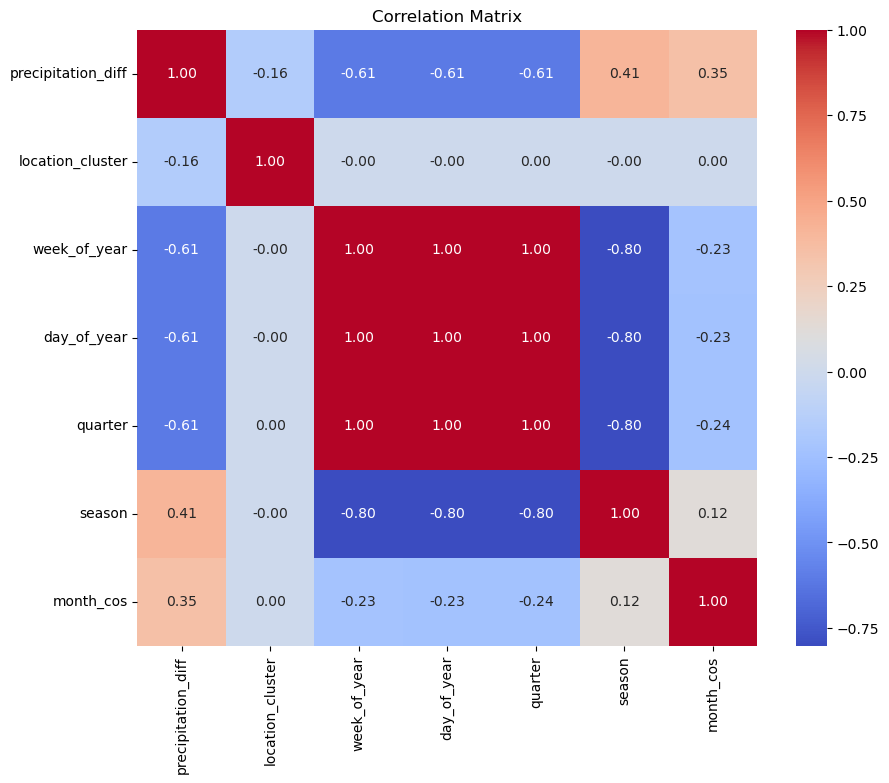

In [31]:
import seaborn as sns

# Compute the correlation matrix
corr = processed_cluster_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

In [32]:
seasonal_VAR = processed_cluster_data.copy()

# seasonal_VAR = seasonal_VAR.reset_index(drop=True)

target = 'precipitation_diff' if 'precipitation_diff' in seasonal_VAR.columns else 'precipitation'

In [33]:
seasonal_VAR

precipitation_diff  location_cluster  week_of_year  day_of_year  \
time                                                                          
1949-01-31            0.401841                 2             5           31   
1949-01-31            0.209754                 1             5           31   
1949-01-31            0.555730                 0             5           31   
1949-04-30            1.094839                 2            17          120   
1949-04-30            0.507573                 1            17          120   
...                        ...               ...           ...          ...   
1994-10-31            0.603704                 2            44          304   
1994-10-31            0.186192                 1            44          304   
1995-01-31            0.800931                 1             5           31   
1995-01-31            1.730091                 2             5           31   
1995-01-31            2.749879                 0             5           31   

            quarter  season  month_cos  
time                                    
1949-01-31        1       3   0.866025  
1949-01-31        1       3   0.866025  
1949-01-31        1       3   0.866025  
1949-04-30        2       1  -0.500000  
1949-04-30        2       1  -0.500000  
...             ...     ...        ...  
1994-10-31        4       0   0.500000  
1994-10-31        4       0   0.500000  
1995-01-31        1       3   0.866025  
1995-01-31        1       3   0.866025  
1995-01-31        1       3   0.866025  

[555 rows x 7 columns]

In [34]:
X = seasonal_VAR.drop([target], axis=1)
y = seasonal_VAR[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression 

In [35]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
coefficients = linear_model.coef_
feature_names = X.columns

# feature importance
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')

location_cluster: -0.11948934693496271
week_of_year: -0.06204160842447315
day_of_year: -0.018048627713360122
quarter: 2.1171335097028443
season: -0.06729810893290308
month_cos: 0.2070978654965582


In [36]:
y_pred = linear_model.predict(X_test)

rmse, mae, r2 = evaluate_model(y_pred, y_test)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.4212
MAE: 0.3339
R-squared: -0.2278


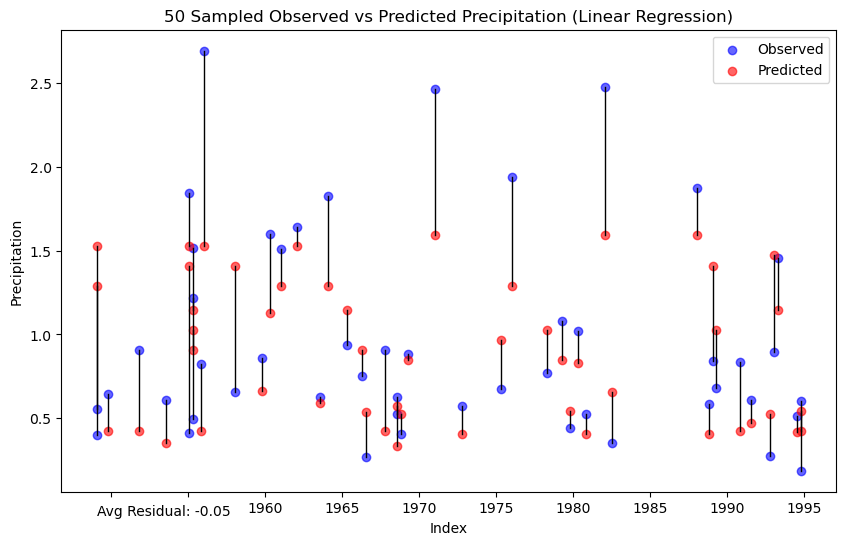

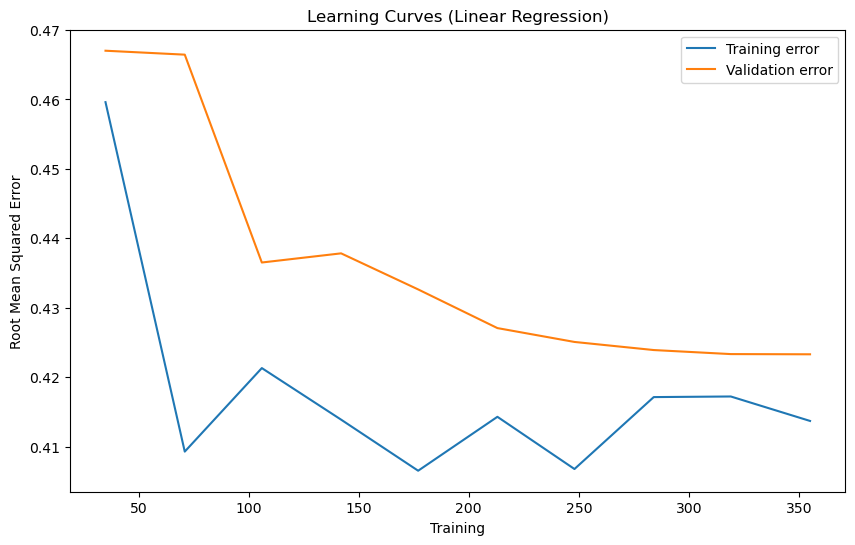

In [37]:
plot_sampled_predictions("Linear Regression", y_test, y_pred, 50)

plot_learning_curves(linear_model, X_train, y_train, 'Linear Regression')

In [38]:
train_score, test_score = plot_model_scores(linear_model, X_train, y_train, X_test, y_test, 'LinearRegression')

### Random Forest

In [39]:
X = seasonal_VAR.drop([target], axis=1)
y = seasonal_VAR[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
rmse, mae, r2 = evaluate_model(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.3002
MAE: 0.1900
R-squared: 0.6796


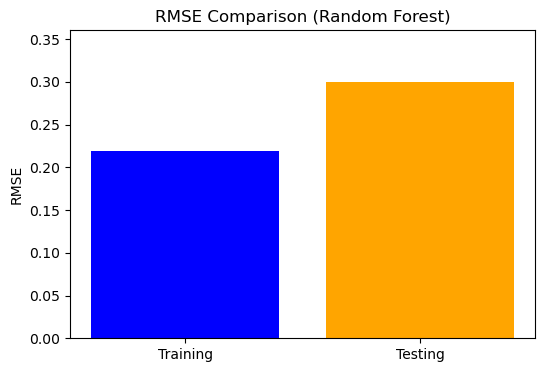

In [41]:
train_score, test_score = plot_model_scores(rf, X_train, y_train, X_test, y_test, 'Random Forest')

Random Forest with Time Series Split 

In [42]:
# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X_rf = seasonal_VAR.drop([target], axis=1)
y_rf = seasonal_VAR[target]

In [43]:
tscv = TimeSeriesSplit(n_splits=5)

In [44]:
rmse_values = []
mae_values = []
r2_values = []
fold_count = 0

actual_values = []
predicted_values = []
predicted_times = []
location_clusters = []

# Iterate over each fold
for train_index, test_index in tscv.split(X_rf):
    # Split data
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y_rf.iloc[train_index], y_rf.iloc[test_index]

    # Retrieve 'time' index from the test set
    times_test = X_test.index
    # print(times_test)
    clusters_test = X_test['location_cluster'].values

    # Train the RandomForestRegressor
    model = RandomForestRegressor(max_depth=8, min_samples_leaf=1, min_samples_split=3,
                                  n_estimators=300, random_state=42)
    # model = RandomForestRegressor(random_state=50)
    
    model.fit(X_train, y_train)

    # Predict using the trained model
    y_pred = model.predict(X_test)

    # Store results
    actual_values.extend(y_test.tolist())
    predicted_values.extend(y_pred.tolist())
    # Collect time information from index
    predicted_times.extend(times_test.tolist())
    location_clusters.extend(clusters_test)

    # Evaluate the model using your evaluate_model function
    rmse, mae, r2 = evaluate_model(y_pred, y_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)
    fold_count += 1
    print(f"Fold {fold_count}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(rmse_values, mae_values, r2_values)
print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}, Average R-squared: {avg_r2:.4f} ")

Fold 1: RMSE = 0.22019493605682072, MAE = 0.15235106807079515, R-squared = 0.8280738030724217
Fold 2: RMSE = 0.228614016847698, MAE = 0.1737026657018297, R-squared = 0.8185561584789991
Fold 3: RMSE = 0.31329856557108354, MAE = 0.2103223051451414, R-squared = 0.6239065584255656
Fold 4: RMSE = 0.1921100019333253, MAE = 0.1566433075976227, R-squared = 0.8668165917858214
Fold 5: RMSE = 0.24189756836619422, MAE = 0.1790512098334505, R-squared = 0.7970064522884105
Average RMSE: 0.2392, Average MAE: 0.1744, Average R-squared: 0.7869 


In [45]:
rf_predict_df = pd.DataFrame({
    'time': predicted_times,
    'location_cluster': location_clusters,
    'actual_values': actual_values,
    'predicted_values': predicted_values
})
rf_predict_df.set_index('time', inplace=True)

In [46]:
sorted_actual_values, sorted_predicted_values = combine_and_sort_actual_predicted(actual_values, predicted_values)

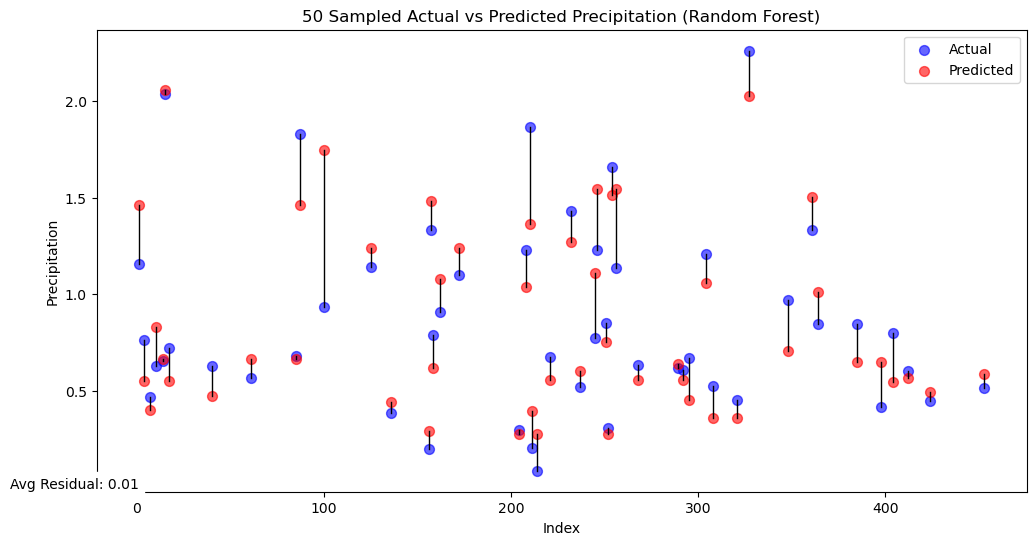

In [47]:
plot_sampled_predictions_actual_predicted(sorted_actual_values, sorted_predicted_values, 'Random Forest', 50)

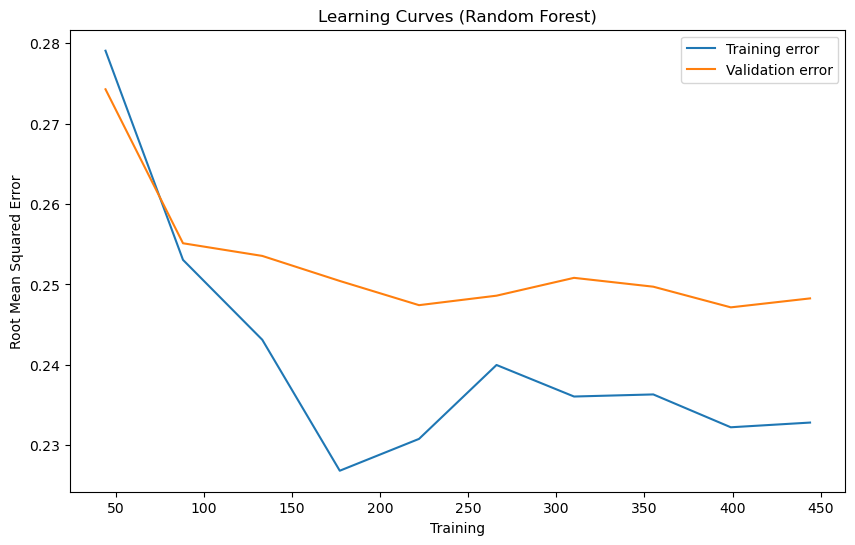

In [48]:
rf = RandomForestRegressor()

plot_learning_curves(rf, X, y, 'Random Forest')

### XGBoost

In [49]:
# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X = seasonal_VAR.drop([target], axis=1)
y = seasonal_VAR[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
xg_boost = XGBRegressor()
xg_boost.fit(X_train, y_train)

# Make predictions
y_pred = xg_boost.predict(X_test)

# Evaluate the model
rmse, mae, r2 = evaluate_model(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.2988
MAE: 0.1886
R-squared: 0.6825


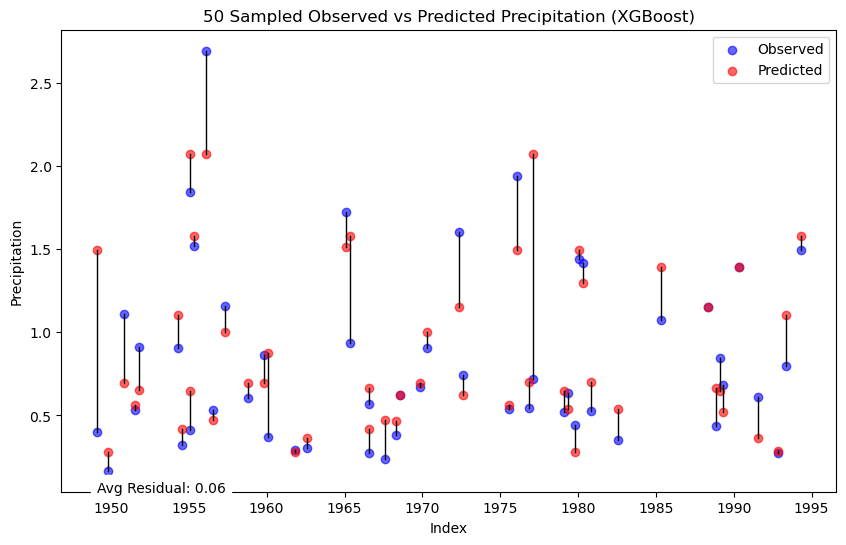

In [51]:
plot_sampled_predictions("XGBoost", y_test, y_pred, 50)

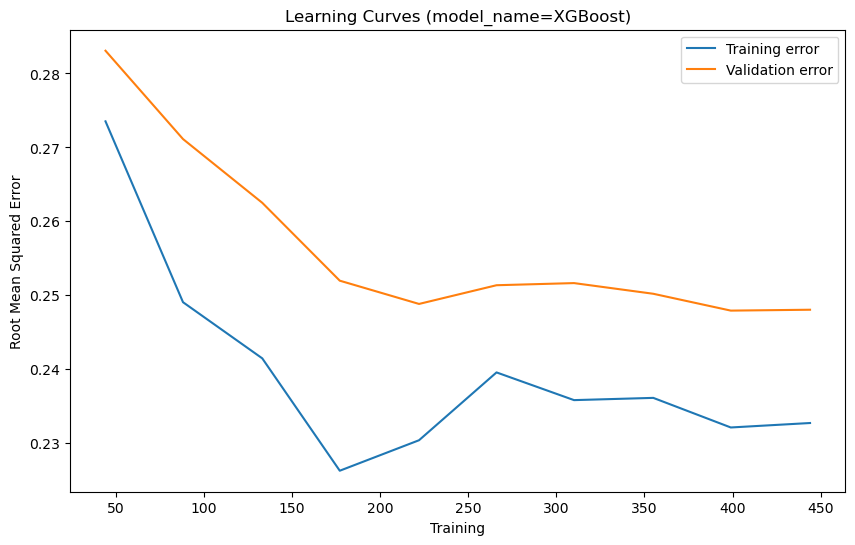

In [52]:
xgb = XGBRegressor()

plot_learning_curves(xgb, X, y, 'model_name=XGBoost')

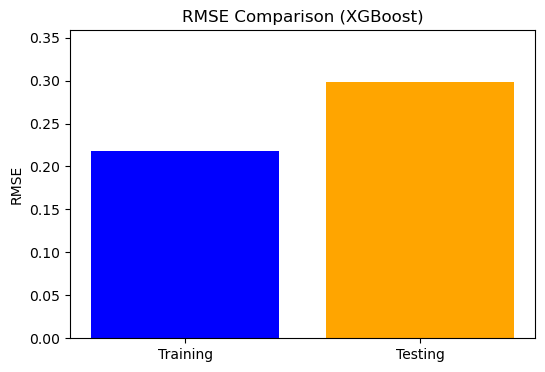

In [53]:
train_score, test_score = plot_model_scores(xg_boost, X_train, y_train, X_test, y_test, 'XGBoost')

Time Series Split XG Boost

In [54]:
tscv = TimeSeriesSplit(n_splits=5)

rmse_values = []
mae_values = []
r2_values = []
fold_count = 0

actual_values = []
predicted_values = []
predicted_times = []
location_clusters = []

# Iterate over each fold
for train_index, test_index in tscv.split(X_rf):
    # Split data
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y_rf.iloc[train_index], y_rf.iloc[test_index]

    # Retrieve 'time' index from the test set
    times_test = X_test.index
    # print(times_test)
    clusters_test = X_test['location_cluster'].values

    # Train the model
    xgb_model =  XGBRegressor(learning_rate = 0.2, 
                          max_depth=6, 
                          n_estimators=60, 
                          random_state=42)
    # xgb_model =  XGBRegressor(random_state=50)

    
    xgb_model.fit(X_train, y_train)

    # Predict using the trained model
    y_pred = xgb_model.predict(X_test)

    # Store results
    actual_values.extend(y_test.tolist())
    predicted_values.extend(y_pred.tolist())
    # Collect time information from index
    predicted_times.extend(times_test.tolist())
    location_clusters.extend(clusters_test)

    # Evaluate the model using your evaluate_model function
    rmse, mae, r2 = evaluate_model(y_pred, y_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)
    fold_count += 1
    print(f"Fold {fold_count}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(rmse_values, mae_values, r2_values)
print(f"Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}, Average R-squared: {avg_r2:.4f} ")

Fold 1: RMSE = 0.23866150141569964, MAE = 0.16223334883986426, R-squared = 0.8063426067158994
Fold 2: RMSE = 0.22732221433271155, MAE = 0.17207805257537387, R-squared = 0.8220577640882413
Fold 3: RMSE = 0.3118941573565772, MAE = 0.21015630922816195, R-squared = 0.6285127308637927
Fold 4: RMSE = 0.19188465255776713, MAE = 0.1564902350215953, R-squared = 0.8663873567484628
Fold 5: RMSE = 0.24212116830403907, MAE = 0.1800022667932594, R-squared = 0.7966869462402425
Average RMSE: 0.2424, Average MAE: 0.1762, Average R-squared: 0.7840 


In [55]:
xgb_predict_df = pd.DataFrame({
    'time': predicted_times,
    'location_cluster': location_clusters,
    'actual_values': actual_values,
    'predicted_values': predicted_values
})
xgb_predict_df.set_index('time', inplace=True)

In [56]:
sorted_actual_values, sorted_predicted_values = combine_and_sort_actual_predicted(actual_values, predicted_values)

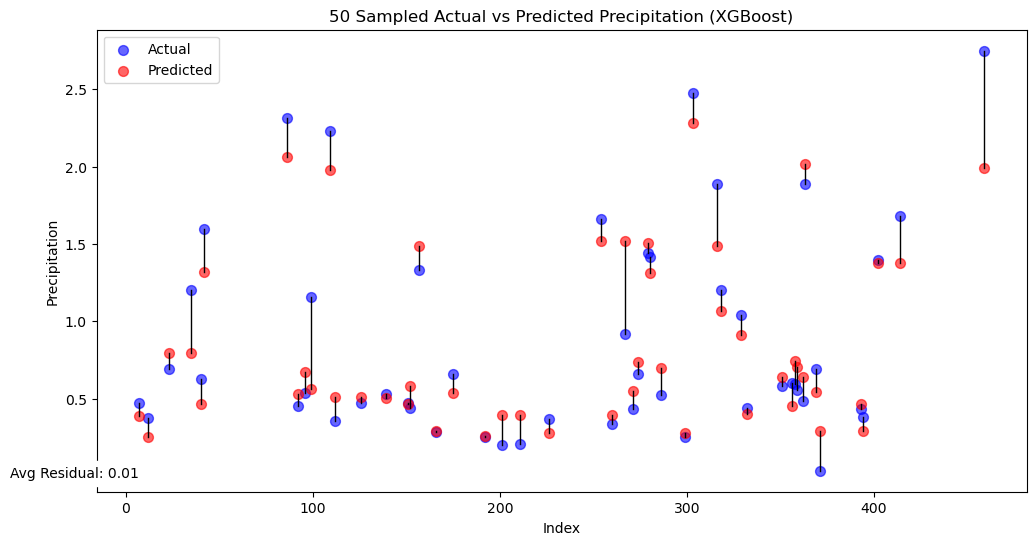

In [57]:
plot_sampled_predictions_actual_predicted(sorted_actual_values, sorted_predicted_values, 'XGBoost', 50)

### ML Models Hyperparameters Tuning (Grid Seach + K Fold Cross Validation)

RANDOM FOREST

In [58]:
df_clusters_RF = processed_cluster_data 

# df_clusters_RF = df_clusters_RF.reset_index(drop=True)

target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_RF.columns else 'precipitation'

In [59]:
df_clusters_RF

precipitation_diff  location_cluster  week_of_year  day_of_year  \
time                                                                          
1949-01-31            0.401841                 2             5           31   
1949-01-31            0.209754                 1             5           31   
1949-01-31            0.555730                 0             5           31   
1949-04-30            1.094839                 2            17          120   
1949-04-30            0.507573                 1            17          120   
...                        ...               ...           ...          ...   
1994-10-31            0.603704                 2            44          304   
1994-10-31            0.186192                 1            44          304   
1995-01-31            0.800931                 1             5           31   
1995-01-31            1.730091                 2             5           31   
1995-01-31            2.749879                 0             5           31   

            quarter  season  month_cos  
time                                    
1949-01-31        1       3   0.866025  
1949-01-31        1       3   0.866025  
1949-01-31        1       3   0.866025  
1949-04-30        2       1  -0.500000  
1949-04-30        2       1  -0.500000  
...             ...     ...        ...  
1994-10-31        4       0   0.500000  
1994-10-31        4       0   0.500000  
1995-01-31        1       3   0.866025  
1995-01-31        1       3   0.866025  
1995-01-31        1       3   0.866025  

[555 rows x 7 columns]

In [60]:
n_splits = 5

kf = KFold(n_splits=n_splits)

scorer = make_scorer(mean_squared_error, squared=False)

In [61]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Perform cross-validation
rmse_scores = cross_val_score(rf_model, X, y, cv=5, scoring=scorer)

print(f"Random Forest : RMSE = {rmse_scores}")

# Calculate the average RMSE
avg_rmse = np.mean(rmse_scores)

print(f"Random Forest : Average RMSE = {avg_rmse}")

Random Forest : RMSE = [0.28297152 0.21337321 0.24207528 0.2646015  0.23220948]
Random Forest : Average RMSE = 0.24704619850297566


### Grid Search Random Forest

In [62]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 8, 10],
    'min_samples_split': [4,6,8],
    'min_samples_leaf': [2,3,4]
}

All Cluster

RMSE

In [63]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

# Perform the grid search
grid_search.fit(X, y)

# Print the best parameters found
best_params = grid_search.best_params_
print(f"Random Forest : Best Parameters - {best_params}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Perform cross-validation with the best model
rmse_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring=scorer)

# Print the average RMSE
avg_rmse = np.mean(rmse_scores)
print(f"Random Forest : Average RMSE - {avg_rmse}")

# Update the results CSV
update_ml_results_csv('ALL', 'Random Forest', best_params, 'RMSE', avg_rmse)

Random Forest : Best Parameters - {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Random Forest : Average RMSE - 0.2476595654559393


Grid Search for Each Cluster

In [64]:
# for cluster_label, cluster_data in df_clusters_RF.groupby('location_cluster'):
#     X = cluster_data.drop(columns=[target])
#     y = cluster_data[target]

#     # Create the Random Forest model
#     rf_model = RandomForestRegressor()

#     # Create the GridSearchCV object
#     grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

#     # Perform the grid search
#     grid_search.fit(X, y)

#     # Print the best parameters found
#     best_params = grid_search.best_params_
#     print(f"Cluster {cluster_label}: Best Parameters - {best_params}")

#     # Get the best model
#     best_rf_model = grid_search.best_estimator_

#     # Perform cross-validation with the best model
#     rmse_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring=scorer)

#     # Print the average RMSE
#     avg_rmse = np.mean(rmse_scores)
#     print(f"Cluster {cluster_label}: Average RMSE - {avg_rmse}")

#     # Update the results CSV
#     update_ml_results_csv(cluster_label, 'Random Forest', best_params, 'RMSE', avg_rmse)

### Grid Search XGBoost

In [65]:
param_grid = {
    'n_estimators': [60, 70, 80, 90, 100],
    'max_depth': [6,7,8],
    'learning_rate': [0.2, 0.3, 0.4, 0.5]
}

In [66]:
# param_grid = {
#     'n_estimators': [60, 70, 80, 90, 100],
#     'max_depth': [6, 7, 8, 9, 10],
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.3],
#     'reg_alpha': [0, 0.1, 0.2, 0.3],
#     'reg_lambda': [0.9, 1.0, 1.1, 1.2],
#     'min_child_weight': [1, 2, 3, 4]
# }

In [67]:
X = df_clusters_RF.drop(columns=[target])
y = df_clusters_RF[target]

xgb_model = XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

# Perform the grid search
grid_search.fit(X, y)

# Print the best parameters found
best_params = grid_search.best_params_
print(f"XGBoost : Best Parameters - {best_params}")

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation with the best model
rmse_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring=scorer)

# Average RMSE
avg_rmse = np.mean(rmse_scores)
print(f"XGBoost : Average RMSE - {avg_rmse}")

# Update the results CSV
update_ml_results_csv('ALL', 'XGBoost', best_params, 'RMSE', avg_rmse)

XGBoost : Best Parameters - {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 60}
XGBoost : Average RMSE - 0.24805911560708985


# Time Series

### Time Series Functions

In [68]:
def evaluate_time_series(test, forecast, model):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    # print(f"{model}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

    return rmse, mae, r2

In [69]:
def plot_avg_actual_vs_forecast(avg_actual, avg_forecast, cluster_label, model_name = None):
    start_index = max(np.argmax(avg_actual != 0), np.argmax(avg_forecast != 0))
    end_index = min(len(avg_actual), len(avg_forecast))
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), avg_actual[start_index:end_index], label='Average Actual')
    plt.plot(range(start_index, end_index), avg_forecast[start_index:end_index], label='Average Forecast')
    plt.title(f"Cluster {cluster_label}: Average Actual vs Forecast  {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Precitation Change")
    plt.legend()
    plt.grid(True)
    plt.show()

In [70]:
def combine_and_sort_actual_forecast(actual_values, forecast_values):
    # Convert forecasts to Series if they are not already, ensuring alignment with actuals
    forecast_series = [pd.Series(forecast, index=actual.index) for forecast, actual in zip(forecast_values, actual_values)]
    
    # Concatenate all Series in the list
    combined_actual_values = pd.concat(actual_values)
    combined_forecast_values = pd.concat(forecast_series)
    
    # If there are overlapping indices, you might want to average the forecasts
    # This step is optional and can be adjusted based on specific needs
    if combined_forecast_values.index.duplicated().any():
        combined_forecast_values = combined_forecast_values.groupby(combined_forecast_values.index).mean()
        combined_actual_values = combined_actual_values.groupby(combined_actual_values.index).mean()

    return combined_actual_values.sort_index(), combined_forecast_values.sort_index()

In [71]:
def reverse_diff_and_clip_forecasts(forecasts, original_diff_data, resample_interval='3M'):
    reversed_forecasts = {}
    target = 'precipitation_diff' if 'precipitation_diff' in original_diff_data.columns else 'precipitation'
    
    # if 'time' not in original_diff_data.index.names:
    #     original_diff_data['time'] = pd.to_datetime(original_diff_data['time'])
    #     original_diff_data.set_index('time', inplace=True, drop=True)

    for cluster, data in forecasts.items():
        # Get the differenced values from the forecasts
        diff_values = data.values
        
        # Get the corresponding original data for the cluster and filter based on forecast index
        original_cluster_data = original_diff_data[original_diff_data['location_cluster'] == cluster]
        original_cluster_data = original_cluster_data[original_cluster_data.index.year.isin(data.index.year)]
        
        # Resample the original data to match the forecast index
        original_cluster_data = extract_process_cluster_data(original_cluster_data, cluster, clip=True)
        original_cluster_data_resampled = original_cluster_data[target].resample(resample_interval).mean()
        
        # # Align the time indices of the original data and the forecasts
        start_date = data.index[0]
        aligned_original_data = original_cluster_data_resampled.loc[start_date:]
        
        # # Reverse the differencing by adding the differenced values to the aligned original data
        reversed_data = aligned_original_data + diff_values
        
        # # Store the reversed data
        reversed_forecasts[cluster] = reversed_data
    
    return reversed_forecasts

## ARIMA

In [72]:
tscv = TimeSeriesSplit(n_splits=5)

In [73]:
df_clusters_ARIMA = processed_cluster_data
target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_ARIMA.columns else 'precipitation'

In [74]:
cluster_order_map = {
    0: (2, 0, 2),
    1: (3, 0, 2),
    2: (3, 1, 2)
}

K-Fold Cross Validation ARIMA

In [75]:
# # Iterate over each cluster
# for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
#     avg_rmse_values = []
#     avg_mae_values = []
#     avg_r2_values = []
#     avg_actual_values = np.zeros(len(cluster_data))
#     avg_forecast_values = np.zeros(len(cluster_data))
#     fold_count = 0

#     # Iterate over each fold of the time series cross-validation
#     for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
#         train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

#         # Fit ARIMA model
#         order = cluster_order_map.get(cluster_label, (0, 0, 1))
#         model = ARIMA(train[target], order=order)
#         model_fit = model.fit()

#         # Forecast
#         forecast = model_fit.forecast(steps=len(test))

#         # Evaluate
#         rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"ARIMA{order}")

#         print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

#         # Accumulate evaluation metrics
#         avg_rmse_values.append(rmse)
#         avg_mae_values.append(mae)
#         avg_r2_values.append(r2)

#         # Accumulate actual and forecast values for averaging
#         avg_actual_values[test_index] += test[target].values
#         avg_forecast_values[test_index] += forecast
#         fold_count += 1

#     # Average actual and forecast values
#     avg_actual_values /= fold_count
#     avg_forecast_values /= fold_count

#     # Plot average actual vs forecast
#     plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'ARIMA')
    

#     # Calculate and print average evaluation metrics
#     avg_rmse = np.mean(avg_rmse_values)
#     avg_mae = np.mean(avg_mae_values)
#     avg_r2 = np.mean(avg_r2_values)

#     print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [76]:
# Initialize dictionaries to store indexed results
cluster_actuals = {}
cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []
    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        
        # Fit ARIMA model
        order = cluster_order_map.get(cluster_label, (0, 0, 1))

        # default param
        # model = ARIMA(train[target])

        # Tuned hyperparameters
        model = ARIMA(train[target], order=order)

        
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"ARIMA{order}")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    cluster_actuals[cluster_label] = sorted_actual_values
    cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 1: RMSE = 0.4415658585183236
Cluster 0, Fold 2: RMSE = 0.4279956287778701
Cluster 0, Fold 3: RMSE = 0.43147565161463347
Cluster 0, Fold 4: RMSE = 0.25980230653019115


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 0, Fold 5: RMSE = 0.2990657513950237
Cluster 0: Average RMSE = 0.3720, Average MAE = 0.2901, Average R-squared = 0.6868 

Cluster 1, Fold 1: RMSE = 0.1539989828002675


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 1, Fold 2: RMSE = 0.174254801717725
Cluster 1, Fold 3: RMSE = 0.1714819943009396


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 1, Fold 4: RMSE = 0.19114016462574362
Cluster 1, Fold 5: RMSE = 0.16318399347165113
Cluster 1: Average RMSE = 0.1708, Average MAE = 0.1296, Average R-squared = 0.3110 

Cluster 2, Fold 1: RMSE = 0.3398222123451721


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 2: RMSE = 0.23996327694456585
Cluster 2, Fold 3: RMSE = 0.6324581424251309
Cluster 2, Fold 4: RMSE = 0.27963019575549225
Cluster 2, Fold 5: RMSE = 0.2659401457498489
Cluster 2: Average RMSE = 0.3516, Average MAE = 0.2965, Average R-squared = 0.2566 



c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [77]:
reversed_data = reverse_diff_and_clip_forecasts(cluster_forecasts, processed_cluster_data)

In [78]:
processed_cluster_data_diff

time  precipitation_diff  location_cluster  year  month  day  \
0    1949-01-31            0.401841                 2  1949      1   31   
1    1949-04-30            1.094839                 2  1949      4   30   
2    1949-07-31            0.355535                 2  1949      7   31   
3    1949-10-31            0.641876                 2  1949     10   31   
4    1950-01-31            1.777431                 2  1950      1   31   
..          ...                 ...               ...   ...    ...  ...   
550  1994-01-31            1.504442                 0  1994      1   31   
551  1994-04-30            1.494714                 0  1994      4   30   
552  1994-07-31            0.512250                 0  1994      7   31   
553  1994-10-31            0.654943                 0  1994     10   31   
554  1995-01-31            2.749879                 0  1995      1   31   

     week_of_year  day_of_week  day_of_year  quarter  season  month_cos  \
0               5            0           31        1  Winter   0.866025   
1              17            5          120        2  Spring  -0.500000   
2              30            6          212        3  Summer  -0.866025   
3              44            0          304        4    Fall   0.500000   
4               5            1           31        1  Winter   0.866025   
..            ...          ...          ...      ...     ...        ...   
550             5            0           31        1  Winter   0.866025   
551            17            5          120        2  Spring  -0.500000   
552            30            6          212        3  Summer  -0.866025   
553            44            0          304        4    Fall   0.500000   
554             5            1           31        1  Winter   0.866025   

     day_of_week_cos  
0           1.000000  
1          -0.222521  
2           0.623490  
3           1.000000  
4           0.623490  
..               ...  
550         1.000000  
551        -0.222521  
552         0.623490  
553         1.000000  
554         0.623490  

[555 rows x 13 columns]

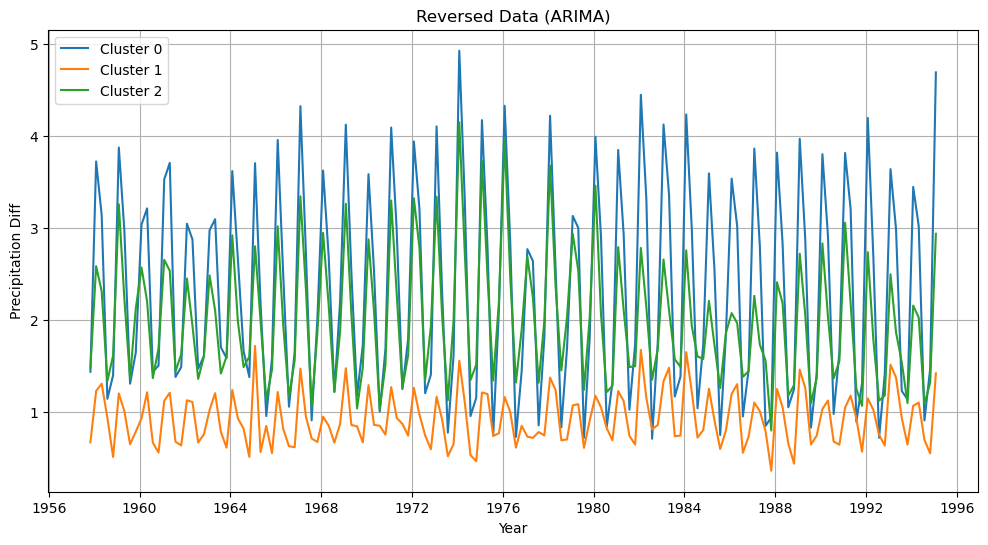

In [79]:
df = pd.DataFrame(reversed_data)

# Plot the data
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=f'Cluster {column}')

plt.xlabel('Year')
plt.ylabel('Precipitation Diff')
plt.title('Reversed Data (ARIMA)')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
def plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels, model_name=None):
    num_clusters = len(cluster_labels)
    plt.figure(figsize=(15, num_clusters * 5))

    for i, cluster_label in enumerate(cluster_labels):
        plt.subplot(num_clusters, 1, i + 1)  # Creates a subplot for each cluster

        # precipitation or precipitation_diff
        plt.plot(cluster_actuals[cluster_label]['precipitation_diff'], label='Actual', marker='o', linestyle='-', markersize=5)
        plt.plot(cluster_forecasts[cluster_label], label='Forecasted', marker='x', linestyle='--', markersize=5)
        plt.title(f'Actual vs Forecasted for Cluster {cluster_label} ({model_name})')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

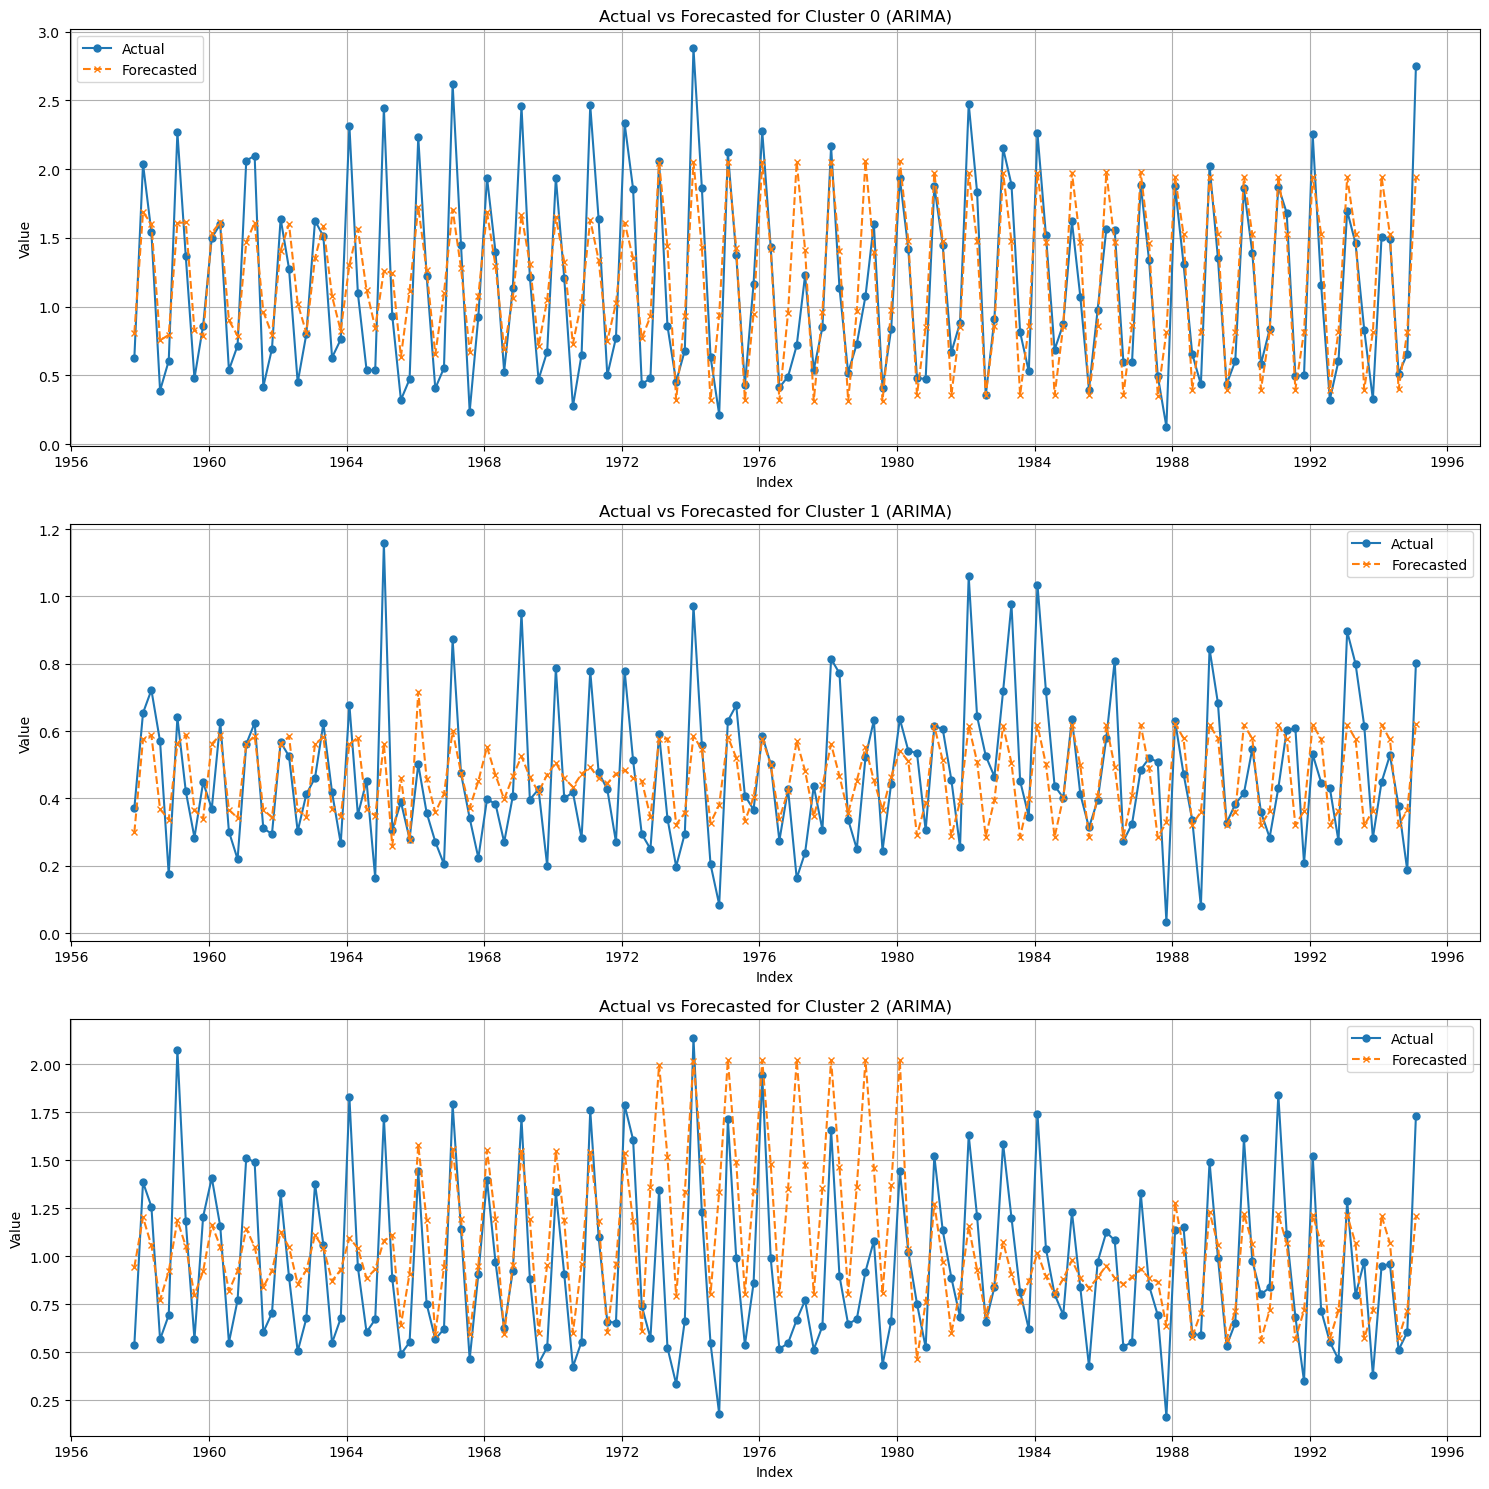

In [81]:
cluster_labels = list(cluster_actuals.keys())
plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels, 'ARIMA')

### Hyperparameters Tuning ARIMA (Grid Search)

In [82]:
# Define the ranges for the parameters
p = range(0, 3) # AR orders
d = range(0, 3) # Differencing order (I)
q = range(0, 3) # MA orders

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q))

Tuning (AIC)

In [83]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_aic = float("inf")
    best_order = None
    avg_aic_values = []  # List to store AIC values within the same fold

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        for param in param_combinations:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit ARIMA model
                    model = ARIMA(train[target], order=param)
                    model_fit = model.fit()

                    # Calculate AIC (Akaike Information Criterion)
                    aic = model_fit.aic
                    avg_aic_values.append(aic)  # Append AIC for this parameter combination

                    # Update best parameters if current model has lower AIC
                    if aic < best_aic:
                        best_aic = aic
                        best_order = param

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    # Calculate average AIC across all folds
    avg_aic_fold = np.mean(avg_aic_values)

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)
    print("  Average AIC across all folds:", avg_aic_fold)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA with Differencing', best_order, 'AIC', best_aic)

Cluster 0:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 208.6899222241296
Cluster 1:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 8.226910240950929
Cluster 2:
  Best ARIMA order: (2, 0, 2)
  Average AIC across all folds: 135.09019721880472


Tuning ARIMA (RMSE)

In [84]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None
    avg_rmse_values = []  # List to store RMSE values within the same fold

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        for param in param_combinations:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    model = ARIMA(train[target], order=param)
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(len(test))

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(test[target], predictions))
                    avg_rmse_values.append(rmse)  # Append RMSE for this parameter combination

                    # Update best parameters if current model has lower RMSE
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = param

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    # Calculate average RMSE across all folds
    avg_rmse_fold = np.mean(avg_rmse_values)

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)
    print("  Average RMSE across all folds:", avg_rmse_fold)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA With Differencing', best_order, 'RMSE', best_rmse)

Cluster 0:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 2.458670152491078
Cluster 1:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 0.6637550393723575
Cluster 2:
  Best ARIMA order: (2, 0, 2)
  Average RMSE across all folds: 1.3705534214645967


## SARIMA

In [85]:
cluster_order_map_sarima = {
    0: ((1, 1, 1), (1, 0, 1, 4)),
    1: ((2, 0, 0), (1, 1, 1, 4)),
    2: ((2, 0, 2), (1, 1, 1, 4))
}

In [86]:
# # Iterate over each cluster
# for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
#     avg_rmse_values = []
#     avg_mae_values = []
#     avg_r2_values = []
#     avg_actual_values = np.zeros(len(cluster_data))
#     avg_forecast_values = np.zeros(len(cluster_data))
#     fold_count = 0

#     order, seasonal_order = cluster_order_map_sarima.get(cluster_label, ((1, 1, 1), (1, 1, 1, 4)))

#     # Iterate over each fold of the time series cross-validation
#     for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
#         train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
#         model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)
#         model_fit = model.fit()

#         # Forecast
#         forecast = model_fit.forecast(steps=len(test))

#         # Evaluate
#         rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"SARIMA{order}")

#         print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

#         # Accumulate evaluation metrics
#         avg_rmse_values.append(rmse)
#         avg_mae_values.append(mae)
#         avg_r2_values.append(r2)

#         # Accumulate actual and forecast values for averaging
#         avg_actual_values[test_index] += test[target].values
#         avg_forecast_values[test_index] += forecast
#         fold_count += 1

#     # Average actual and forecast values
#     avg_actual_values /= fold_count
#     avg_forecast_values /= fold_count

#     # Plot average actual vs forecast
#     plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'SARIMA')

#     # Calculate and print average evaluation metrics
#     avg_rmse = np.mean(avg_rmse_values)
#     avg_mae = np.mean(avg_mae_values)
#     avg_r2 = np.mean(avg_r2_values)

#     print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [87]:
# Initialize dictionaries to store indexed results
sarima_cluster_actuals = {}
sarima_cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []

    order, seasonal_order = cluster_order_map_sarima.get(cluster_label, ((1, 1, 1), (1, 1, 1, 4)))

    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Default SARIMA model
        # model = SARIMAX(train[target])

        # With Tuned Hyper prameters
        model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)


        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"SARIMA{order}")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    sarima_cluster_actuals[cluster_label] = sorted_actual_values
    sarima_cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

Cluster 0, Fold 1: RMSE = 0.24620796179582494


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cluster 0, Fold 2: RMSE = 0.26385106883569764


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting 

Cluster 0, Fold 3: RMSE = 0.4204999977747386
Cluster 0, Fold 4: RMSE = 0.2444339494053366
Cluster 0, Fold 5: RMSE = 0.27220007156806286
Cluster 0: Average RMSE = 0.2894, Average MAE = 0.2106, Average R-squared = 0.8067 

Cluster 1, Fold 1: RMSE = 0.16062117094265357
Cluster 1, Fold 2: RMSE = 0.12947466895096832
Cluster 1, Fold 3: RMSE = 0.1748907424865689
Cluster 1, Fold 4: RMSE = 0.17561105344106745
Cluster 1, Fold 5: RMSE = 0.15046605080570946
Cluster 1: Average RMSE = 0.1582, Average MAE = 0.1254, Average R-squared = 0.4085 



c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 1: RMSE = 0.21452026495896498


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 2: RMSE = 0.19436128478865544


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cluster 2, Fold 3: RMSE = 0.3216158863020047
Cluster 2, Fold 4: RMSE = 0.18121407010427015
Cluster 2, Fold 5: RMSE = 0.2421379793844146
Cluster 2: Average RMSE = 0.2308, Average MAE = 0.1733, Average R-squared = 0.7004 



In [88]:
cluster_labels = list(cluster_actuals.keys())
plot_cluster_data(cluster_actuals, cluster_forecasts, cluster_labels, 'SARIMA')

### Hyperparameters Tuning SARIMA (Grid Search)

In [89]:
# Define the ranges for the parameters
p = range(1, 3) # AR
d = range(0, 3) # I
q = range(1, 3) # MA
P = D = Q = range(1, 2)  # Seasonal AR, I, MA
s = 4  # Seasonal period (quarterly seasonality)

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q))

AIC

In [90]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        avg_aic_values = []

        for param in param_combinations:
            seasonal_order = param[3:6]  # Unpack the seasonal order (P, D, Q)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting seasonal autoregressive")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit SARIMA model
                    model = SARIMAX(train[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                    model_fit = model.fit()

                    # Calculate AIC
                    aic = model_fit.aic
                    avg_aic_values.append(aic)  # Append AIC for this parameter combination

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

        # Calculate average AIC within the same fold
        avg_aic_fold = np.mean(avg_aic_values)
        # print(f"Cluster {cluster_label}, Fold {fold_count}: Average AIC within fold = {avg_aic_fold}")

        # Update best parameters if current model has lower AIC
        if avg_aic_fold < best_aic:
            best_aic = avg_aic_fold
            best_order = param[:3]
            best_seasonal_order = seasonal_order

    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)
    print("  Average AIC across all folds:", best_aic)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA With Differencing', best_order + best_seasonal_order + (s,), 'AIC', best_aic)

Cluster 0:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average AIC across all folds: 52.52097328704639
Cluster 1:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average AIC across all folds: -94.85341850076617
Cluster 2:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average AIC across all folds: 23.283444832829275


RMSE

In [91]:
tscv = TimeSeriesSplit(n_splits=5)

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None
    best_seasonal_order = None

    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        avg_rmse_values = []

        for param in param_combinations:
            seasonal_order = param[3:6]  # Unpack the seasonal order (P, D, Q)

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Non-stationary starting seasonal autoregressive")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
                try:
                    # Fit SARIMA model
                    model = SARIMAX(train[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(len(test))  # Forecast for the test set

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(test[target], predictions))
                    avg_rmse_values.append(rmse)  # Append RMSE for this parameter combination

                except Exception as e:
                    print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

        # Calculate average RMSE within the same fold
        avg_rmse_fold = np.mean(avg_rmse_values)
        # print(f"Cluster {cluster_label}, Fold {fold_count}: Average RMSE within fold = {avg_rmse_fold}")

        # Update best parameters if current model has lower RMSE
        if avg_rmse_fold < best_rmse:
            best_rmse = avg_rmse_fold
            best_order = param[:3]
            best_seasonal_order = seasonal_order

    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)
    print("  Average RMSE across all folds:", best_rmse)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA With Diffencing', best_order + best_seasonal_order + (s,), 'RMSE', best_rmse)

Cluster 0:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average RMSE across all folds: 0.2949931775152535
Cluster 1:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average RMSE across all folds: 0.15589157864926903
Cluster 2:
  Best SARIMA order: (2, 2, 2)
  Best SARIMA seasonal order: (1, 1, 1)
  Average RMSE across all folds: 0.2404085095545843


## Exponential Smoothing (HOLT WINTER)

In [92]:
# for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):

#     avg_rmse_values = []
#     avg_mae_values = []
#     avg_r2_values = []
#     avg_actual_values = np.zeros(len(cluster_data))
#     avg_forecast_values = np.zeros(len(cluster_data))
#     fold_count = 0

#     # Iterate over each fold of the time series cross-validation
#     for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
#         train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

#         # Fit Holt-Winters model
#         model = ExponentialSmoothing(train[target], trend='add',seasonal='add', seasonal_periods=4)
#         model_fit = model.fit()

#         # Forecast
#         forecast = model_fit.forecast(len(test))

#         # Evaluate
#         rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"Holt Winter")

#         print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

#         # Accumulate evaluation metrics
#         avg_rmse_values.append(rmse)
#         avg_mae_values.append(mae)
#         avg_r2_values.append(r2)

#         # Accumulate actual and forecast values for averaging
#         avg_actual_values[test_index] += test[target].values
#         avg_forecast_values[test_index] += forecast
#         fold_count += 1

#     # Average actual and forecast values
#     avg_actual_values /= fold_count
#     avg_forecast_values /= fold_count

#     # Plot average actual vs forecast
#     plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label, 'Holt Winter')

#     # Calculate and print average evaluation metrics
#     avg_rmse = np.mean(avg_rmse_values)
#     avg_mae = np.mean(avg_mae_values)
#     avg_r2 = np.mean(avg_r2_values)

#     print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

In [93]:
tscv = TimeSeriesSplit(n_splits=2)

In [94]:
# Initialize dictionaries to store indexed results
hw_cluster_actuals = {}
hw_cluster_forecasts = {}

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    actual_values = []
    forecast_values = []
    
    # Iterate over each fold of the time series cross-validation
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(cluster_data), 1):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Default Model
        # model = ExponentialSmoothing(train[target])

        # With Tuned Hyper Parameters 
        model = ExponentialSmoothing(train[target], trend='add',seasonal='add', seasonal_periods=4)
        
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"Holt Winter")
        print(f"Cluster {cluster_label}, Fold {fold_idx}: RMSE = {rmse}")

        actual_values.append(test)
        forecast_values.append(forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    sorted_actual_values, sorted_forecast_values = combine_and_sort_actual_forecast(actual_values, forecast_values)

    # Concatenate results with indices preserved
    hw_cluster_actuals[cluster_label] = sorted_actual_values
    hw_cluster_forecasts[cluster_label] = sorted_forecast_values

    avg_rmse, avg_mae, avg_r2 = calculate_average_metrics(avg_rmse_values, avg_mae_values, avg_r2_values)
    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}, Average R-squared = {avg_r2:.4f} \n")

Cluster 0, Fold 1: RMSE = 0.34346363587602485
Cluster 0, Fold 2: RMSE = 0.2545142982601578
Cluster 0: Average RMSE = 0.2990, Average MAE = 0.2215, Average R-squared = 0.8104 

Cluster 1, Fold 1: RMSE = 0.16801864132559485
Cluster 1, Fold 2: RMSE = 0.1646514500768537
Cluster 1: Average RMSE = 0.1663, Average MAE = 0.1259, Average R-squared = 0.4220 

Cluster 2, Fold 1: RMSE = 0.2933567366669565
Cluster 2, Fold 2: RMSE = 0.21137672903675225
Cluster 2: Average RMSE = 0.2524, Average MAE = 0.2005, Average R-squared = 0.6524 



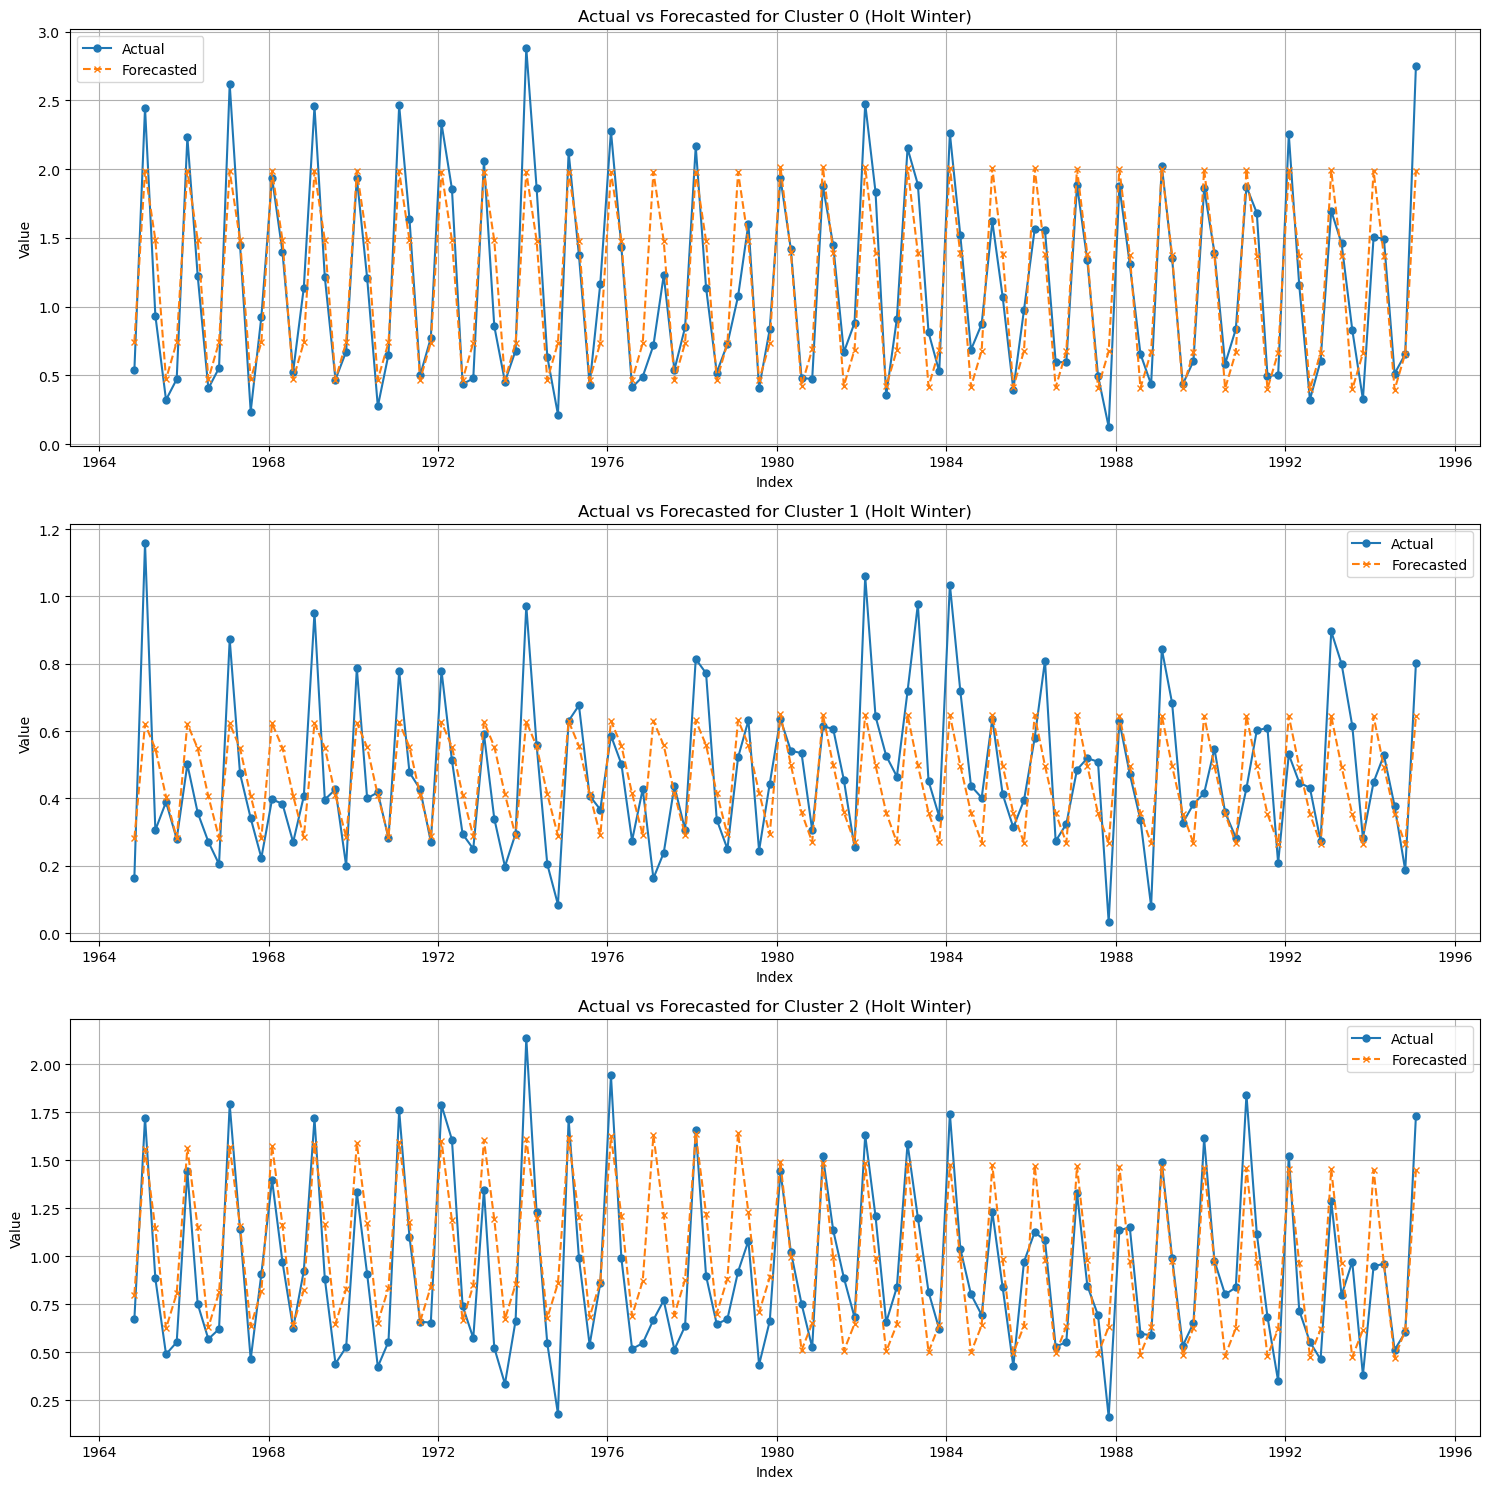

In [95]:
cluster_labels = list(cluster_actuals.keys())
plot_cluster_data(hw_cluster_actuals, hw_cluster_forecasts, cluster_labels, 'Holt Winter')

HOLT WINTER Hyperparameters Tuning

In [96]:
# Function to evaluate Holt-Winters model with given hyperparameters
def evaluate_holt_winters(train, test, trend, seasonal, seasonal_period):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    return rmse, mae, r2

In [97]:
trend_types = ['add', 'mul']
seasonal_types = ['add', 'mul']
seasonal_periods = [4, 12]  # Quarterly and monthly seasonality

# tscv = TimeSeriesSplit(n_splits=5)

In [98]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_trend = None
    best_seasonal = None
    best_seasonal_period = None

    # Iterate over hyperparameters
    for trend in trend_types:
        for seasonal in seasonal_types:
            for period in seasonal_periods:
                avg_rmse_values = []
                for train_index, test_index in tscv.split(cluster_data):
                    train, test = cluster_data.iloc[train_index][target], cluster_data.iloc[test_index][target]
                    rmse, _, _ = evaluate_holt_winters(train, test, trend, seasonal, period)
                    avg_rmse_values.append(rmse)
                avg_rmse = np.mean(avg_rmse_values)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_trend = trend
                    best_seasonal = seasonal
                    best_seasonal_period = period

    print(f"Cluster {cluster_label}: Best RMSE = {best_rmse}, Trend = {best_trend}, Seasonal = {best_seasonal}, Seasonal Period = {best_seasonal_period}")

    update_results_csv(cluster_label, 'Holt-Winters', f'Best Trend = {best_trend}, Best Seasonal = {best_seasonal}', 'RMSE', best_rmse)

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Cluster 0: Best RMSE = 0.2982057376593545, Trend = mul, Seasonal = mul, Seasonal Period = 4


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Cluster 1: Best RMSE = 0.1653285241857128, Trend = mul, Seasonal = mul, Seasonal Period = 4


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Cluster 2: Best RMSE = 0.251392899500116, Trend = add, Seasonal = mul, Seasonal Period = 4


## Ensembling Models (RF + HW)

In [99]:
ensemble_df = rf_predict_df
# ensemble_df['ml_predictions'] = sorted_predicted_values

In [100]:
ensemble_df = ensemble_df.reset_index()

In [101]:
ensemble_df 

time  location_cluster  actual_values  predicted_values
0   1956-10-31                 1       0.368062          0.201608
1   1957-01-31                 2       1.156035          1.461106
2   1957-01-31                 1       0.422155          0.665917
3   1957-01-31                 0       1.320085          2.059735
4   1957-04-30                 1       0.761881          0.548009
..         ...               ...            ...               ...
455 1994-10-31                 2       0.603704          0.704547
456 1994-10-31                 1       0.186192          0.288793
457 1995-01-31                 1       0.800931          0.646628
458 1995-01-31                 2       1.730091          1.486656
459 1995-01-31                 0       2.749879          2.001192

[460 rows x 4 columns]

In [102]:
forecast_dict = hw_cluster_forecasts

In [103]:
# Initialize an empty DataFrame to collect all forecasts
all_forecasts_df = pd.DataFrame()

# Loop through each cluster label and corresponding forecast series
for cluster_label, cluster_forecast_series in forecast_dict.items():
    # Convert series to DataFrame and reset index
    forecast_df = cluster_forecast_series.reset_index()
    forecast_df.columns = ['time', 'ts_forecast'] 

    forecast_df['location_cluster'] = cluster_label

    # Concatenate to the existing DataFrame
    all_forecasts_df = pd.concat([all_forecasts_df, forecast_df], ignore_index=True)

In [104]:
for index, row in all_forecasts_df.iterrows():
    # Find the corresponding row in ensemble_df based on location and time
    matching_rows = ensemble_df[(ensemble_df['location_cluster'] == row['location_cluster']) & (ensemble_df['time'] == row['time'])]
    
    # If a matching row is found, update the 'ts_forecast' column in ensemble_df
    if not matching_rows.empty:
        ensemble_df.loc[matching_rows.index, 'ts_forecast'] = row['ts_forecast']


ensemble_df.dropna(subset=['ts_forecast'], inplace=True)

In [105]:
ensemble_df

time  location_cluster  actual_values  predicted_values  ts_forecast
94  1964-10-31                 2       0.671196          0.717982     0.799976
95  1964-10-31                 1       0.164077          0.249290     0.281114
96  1964-10-31                 0       0.535605          0.667990     0.743095
97  1965-01-31                 2       1.721482          1.612633     1.557958
98  1965-01-31                 0       2.446541          2.086345     1.987686
..         ...               ...            ...               ...          ...
455 1994-10-31                 2       0.603704          0.704547     0.613205
456 1994-10-31                 1       0.186192          0.288793     0.264648
457 1995-01-31                 1       0.800931          0.646628     0.643461
458 1995-01-31                 2       1.730091          1.486656     1.447561
459 1995-01-31                 0       2.749879          2.001192     1.986868

[366 rows x 5 columns]

Weighted Average

In [106]:
ensemble_df['weighted_average_forecast'] = (ensemble_df['predicted_values'] * 0.5 + ensemble_df['ts_forecast'] * 0.5)

In [107]:
# rmse_ml = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['predicted_values']))
# rmse_ts = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['ts_forecast']))
# rmse_ensemble = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['weighted_average_forecast']))

# print(f"RMSE for Machine Learning Predictions: {rmse_ml}")
# print(f"RMSE for Time Series Forecasts: {rmse_ts}")
# print(f"RMSE for Ensemble Forecasts: {rmse_ensemble}")

In [108]:
ensemble_df

time  location_cluster  actual_values  predicted_values  \
94  1964-10-31                 2       0.671196          0.717982   
95  1964-10-31                 1       0.164077          0.249290   
96  1964-10-31                 0       0.535605          0.667990   
97  1965-01-31                 2       1.721482          1.612633   
98  1965-01-31                 0       2.446541          2.086345   
..         ...               ...            ...               ...   
455 1994-10-31                 2       0.603704          0.704547   
456 1994-10-31                 1       0.186192          0.288793   
457 1995-01-31                 1       0.800931          0.646628   
458 1995-01-31                 2       1.730091          1.486656   
459 1995-01-31                 0       2.749879          2.001192   

     ts_forecast  weighted_average_forecast  
94      0.799976                   0.758979  
95      0.281114                   0.265202  
96      0.743095                   0.705543  
97      1.557958                   1.585296  
98      1.987686                   2.037015  
..           ...                        ...  
455     0.613205                   0.658876  
456     0.264648                   0.276720  
457     0.643461                   0.645044  
458     1.447561                   1.467109  
459     1.986868                   1.994030  

[366 rows x 6 columns]

In [109]:
clusters = [0,1,2]
rmse_data = {'ML': [], 'TS': [], 'weighted': [], 'Cluster': []}

# Calculate RMSE for each cluster
for cluster in clusters:
    subset = ensemble_df[ensemble_df['location_cluster'] == cluster]
    
    rmse_ml = np.sqrt(mean_squared_error(subset['actual_values'], subset['predicted_values']))
    rmse_ts = np.sqrt(mean_squared_error(subset['actual_values'], subset['ts_forecast']))
    rmse_ensemble = np.sqrt(mean_squared_error(subset['actual_values'], subset['weighted_average_forecast']))
    
    rmse_data['ML'].append(rmse_ml)
    rmse_data['TS'].append(rmse_ts)
    rmse_data['weighted'].append(rmse_ensemble)
    rmse_data['Cluster'].append(cluster)
    
    print(f"Cluster {cluster} RMSE for Machine Learning Predictions: {rmse_ml:.4f}")
    print(f"Cluster {cluster} RMSE for Time Series Forecasts: {rmse_ts:.4f}")
    print(f"Cluster {cluster} RMSE for weighted Average Forecasts: {rmse_ensemble:.4f}")

Cluster 0 RMSE for Machine Learning Predictions: 0.3165
Cluster 0 RMSE for Time Series Forecasts: 0.3023
Cluster 0 RMSE for weighted Average Forecasts: 0.3056
Cluster 1 RMSE for Machine Learning Predictions: 0.1674
Cluster 1 RMSE for Time Series Forecasts: 0.1663
Cluster 1 RMSE for weighted Average Forecasts: 0.1653
Cluster 2 RMSE for Machine Learning Predictions: 0.2390
Cluster 2 RMSE for Time Series Forecasts: 0.2557
Cluster 2 RMSE for weighted Average Forecasts: 0.2416


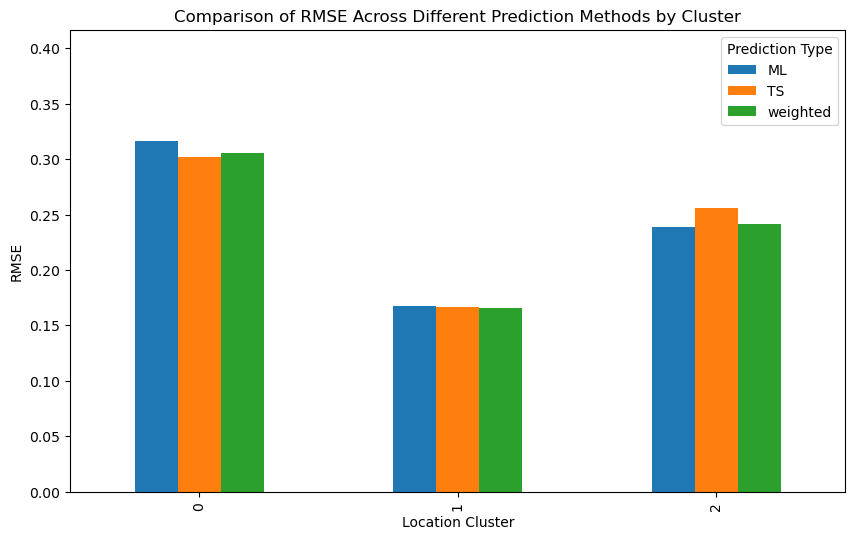

In [110]:
# Plotting
df_rmse = pd.DataFrame(rmse_data)
df_rmse.set_index('Cluster', inplace=True)
df_rmse.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of RMSE Across Different Prediction Methods by Cluster')
plt.xlabel('Location Cluster')
plt.ylabel('RMSE')
plt.ylim(0, df_rmse.max().max() + 0.1)  # Set y-limit for better visualization
plt.legend(title='Prediction Type')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23288\1421781388.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values('time', inplace=True)


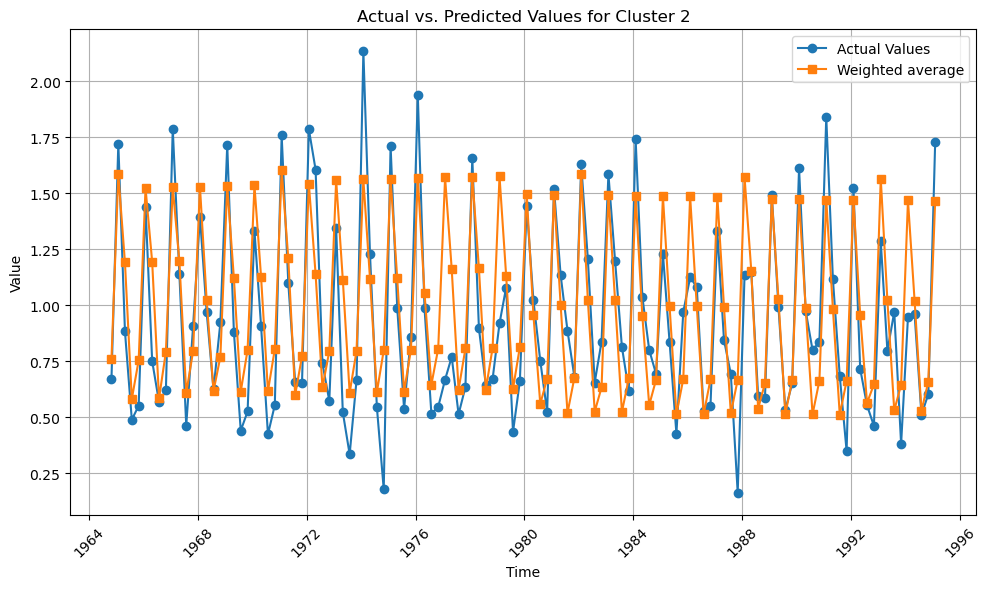

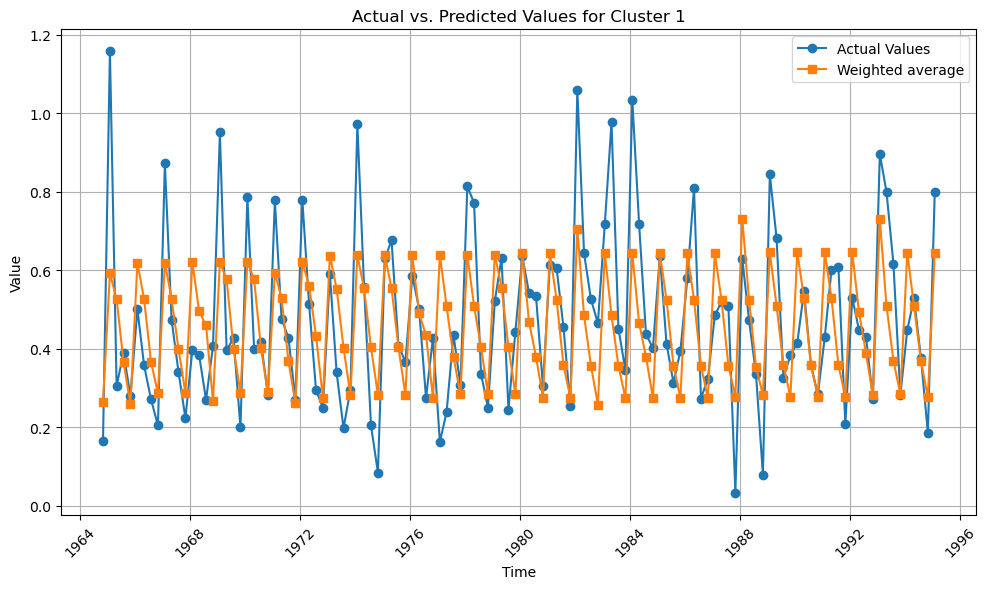

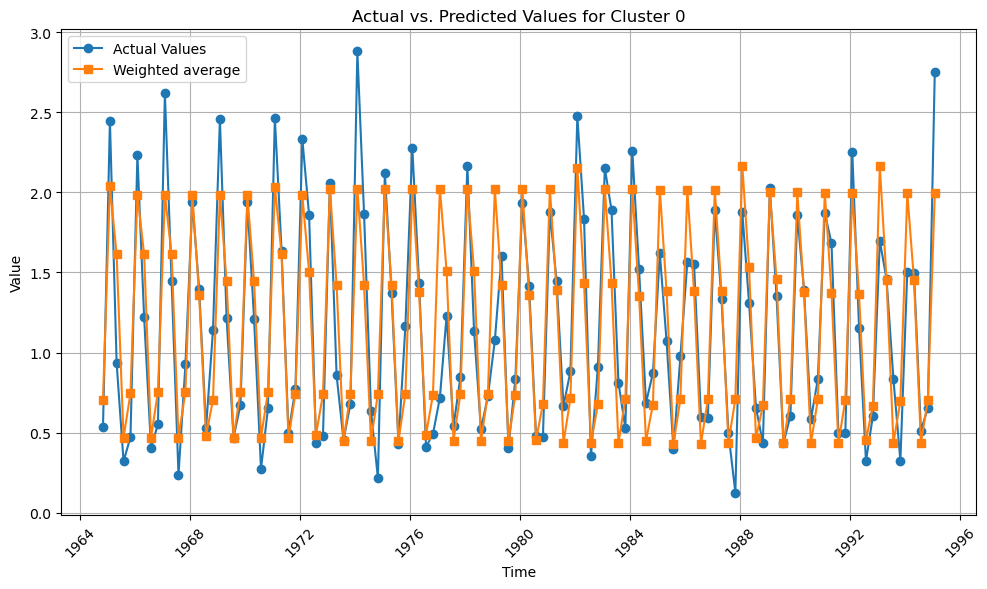

In [111]:
clusters = ensemble_df['location_cluster'].unique()
for cluster in clusters:
    # Subset the DataFrame by cluster
    subset = ensemble_df[ensemble_df['location_cluster'] == cluster]
    
    # Sorting by time to make line plots make sense
    subset.sort_values('time', inplace=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['time'], subset['actual_values'], label='Actual Values', marker='o')
    # plt.plot(subset['time'], subset['predicted_values'], label='ML Predictions', marker='x')
    # plt.plot(subset['time'], subset['ts_forecast'], label='Time Series Forecast', marker='^')
    plt.plot(subset['time'], subset['weighted_average_forecast'], label='Weighted average', marker='s')
    
    plt.title(f'Actual vs. Predicted Values for Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Model Stacking

In [112]:
from sklearn.linear_model import LinearRegression

# Prepare the new training set from the forecasts
X_ensemble = ensemble_df[['predicted_values', 'ts_forecast']]
y_ensemble = ensemble_df['actual_values']

# Train a new model to learn how to combine the forecasts
model = LinearRegression()
model.fit(X_ensemble, y_ensemble)

# Use the trained model to make the ensemble prediction
ensemble_df['Stacked_forecast'] = model.predict(X_ensemble)

In [113]:
rmse = mean_squared_error(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'], squared=False)
mae = mean_absolute_error(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'])
r2 = r2_score(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'])

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")


RMSE: 0.2436, MAE: 0.1774, R-squared: 0.8119


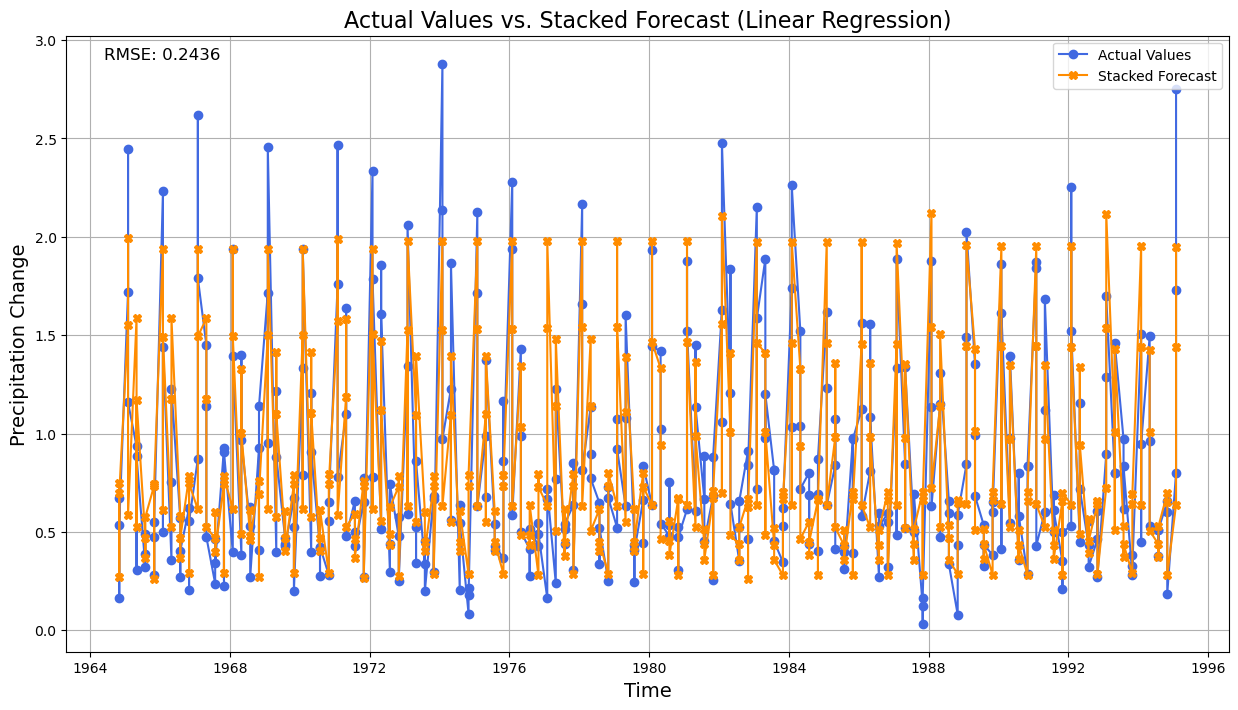

In [114]:
plt.figure(figsize=(15, 8))

# Plotting actual values
plt.plot(ensemble_df['time'], ensemble_df['actual_values'], label='Actual Values', 
         marker='o', color='royalblue')

# Plotting stacked forecast
plt.plot(ensemble_df['time'], ensemble_df['Stacked_forecast'], label='Stacked Forecast', 
         marker='X', linestyle='-', color='darkorange')

# Adding title and labels
plt.title('Actual Values vs. Stacked Forecast (Linear Regression)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Precipitation Change', fontsize=14)

# Adding RMSE to the plot
plt.figtext(0.15, 0.85, f'RMSE: {rmse:.4f}', fontsize=12, ha='left', color='Black')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
window_size = 7

# Exponential Moving Average
ensemble_df['EMA_actual'] = ensemble_df['actual_values'].ewm(span=window_size, adjust=False).mean()
ensemble_df['EMA_forecast'] = ensemble_df['Stacked_forecast'].ewm(span=window_size, adjust=False).mean()

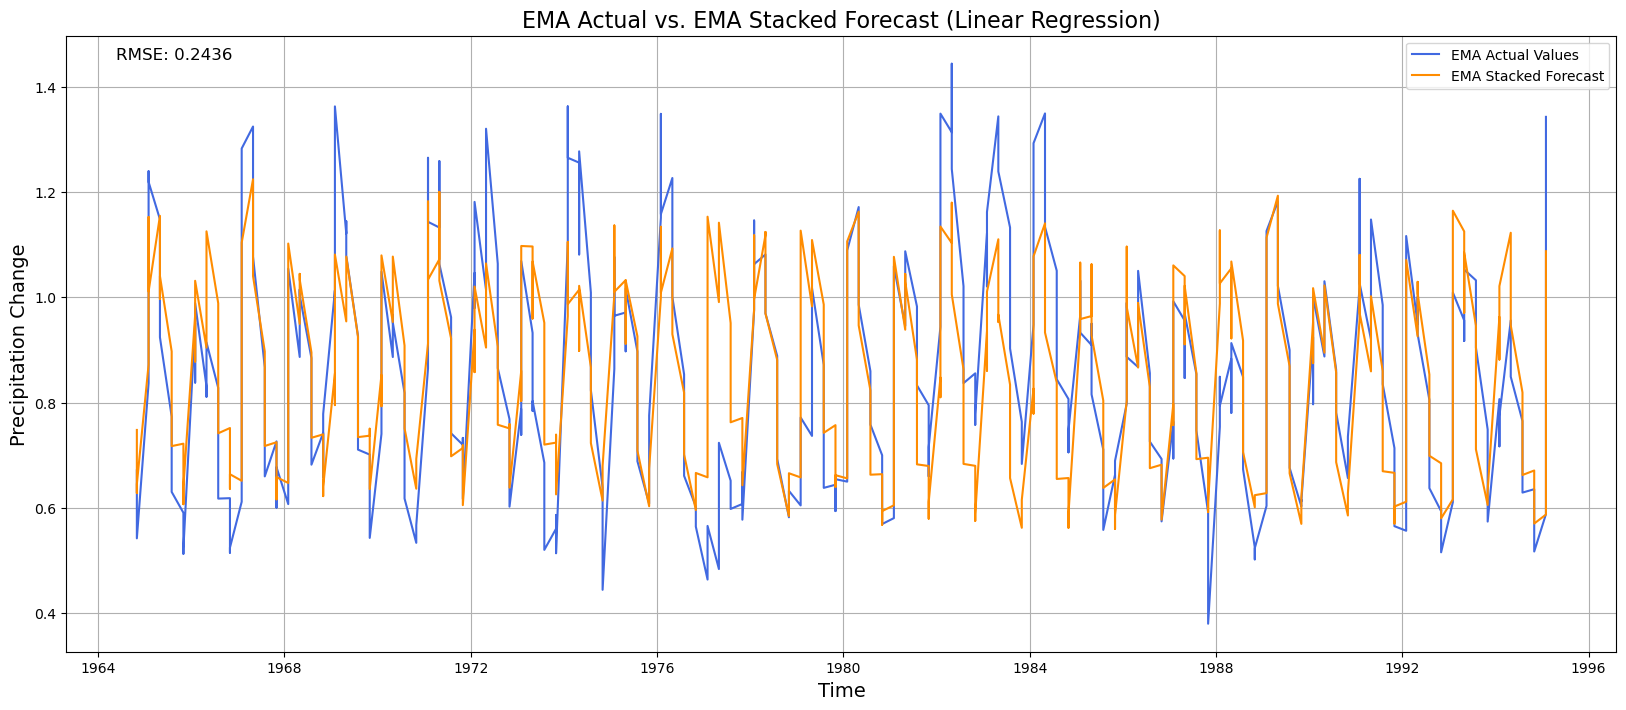

In [116]:
# Plotting with fewer markers
plt.figure(figsize=(20, 8))
plt.plot(ensemble_df['time'], ensemble_df['EMA_actual'], label='EMA Actual Values', linestyle='-', color='royalblue')
plt.plot(ensemble_df['time'], ensemble_df['EMA_forecast'], label='EMA Stacked Forecast', linestyle='-', color='darkorange')

# Additional Plot settings
plt.title('EMA Actual vs. EMA Stacked Forecast (Linear Regression)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Precipitation Change', fontsize=14)
plt.figtext(0.15, 0.85, f'RMSE: {rmse:.4f}', fontsize=12, ha='left', color='black')
plt.legend()
plt.grid(True)
plt.show()

## Ensembling Models (RF + SARIMA)

In [117]:
ensemble_df = rf_predict_df
# ensemble_df['ml_predictions'] = sorted_predicted_values

In [118]:
ensemble_df = ensemble_df.reset_index()

In [119]:
ensemble_df 

time  location_cluster  actual_values  predicted_values
0   1956-10-31                 1       0.368062          0.201608
1   1957-01-31                 2       1.156035          1.461106
2   1957-01-31                 1       0.422155          0.665917
3   1957-01-31                 0       1.320085          2.059735
4   1957-04-30                 1       0.761881          0.548009
..         ...               ...            ...               ...
455 1994-10-31                 2       0.603704          0.704547
456 1994-10-31                 1       0.186192          0.288793
457 1995-01-31                 1       0.800931          0.646628
458 1995-01-31                 2       1.730091          1.486656
459 1995-01-31                 0       2.749879          2.001192

[460 rows x 4 columns]

In [120]:
forecast_dict = sarima_cluster_forecasts

In [121]:
# Initialize an empty DataFrame to collect all forecasts
all_forecasts_df = pd.DataFrame()

# Loop through each cluster label and corresponding forecast series
for cluster_label, cluster_forecast_series in forecast_dict.items():
    # Convert series to DataFrame and reset index
    forecast_df = cluster_forecast_series.reset_index()
    forecast_df.columns = ['time', 'ts_forecast'] 

    forecast_df['location_cluster'] = cluster_label

    # Concatenate to the existing DataFrame
    all_forecasts_df = pd.concat([all_forecasts_df, forecast_df], ignore_index=True)

In [122]:
for index, row in all_forecasts_df.iterrows():
    # Find the corresponding row in ensemble_df based on location and time
    matching_rows = ensemble_df[(ensemble_df['location_cluster'] == row['location_cluster']) & (ensemble_df['time'] == row['time'])]
    
    # If a matching row is found, update the 'ts_forecast' column in ensemble_df
    if not matching_rows.empty:
        ensemble_df.loc[matching_rows.index, 'ts_forecast'] = row['ts_forecast']


ensemble_df.dropna(subset=['ts_forecast'], inplace=True)

In [123]:
ensemble_df

time  location_cluster  actual_values  predicted_values  ts_forecast
10  1957-10-31                 0       0.628733          0.830526     0.832216
11  1957-10-31                 2       0.539602          0.792040     0.668266
12  1957-10-31                 1       0.371283          0.252812     0.256963
13  1958-01-31                 2       1.384597          1.461106     1.730566
14  1958-01-31                 1       0.653892          0.665917     0.822828
..         ...               ...            ...               ...          ...
455 1994-10-31                 2       0.603704          0.704547     0.697280
456 1994-10-31                 1       0.186192          0.288793     0.313108
457 1995-01-31                 1       0.800931          0.646628     0.679994
458 1995-01-31                 2       1.730091          1.486656     1.525878
459 1995-01-31                 0       2.749879          2.001192     1.891735

[450 rows x 5 columns]

Weighted Average

In [124]:
ensemble_df['weighted_average_forecast'] = (ensemble_df['predicted_values'] * 0.5 + ensemble_df['ts_forecast'] * 0.5)

In [125]:
# rmse_ml = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['predicted_values']))
# rmse_ts = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['ts_forecast']))
# rmse_ensemble = np.sqrt(mean_squared_error(ensemble_df['actual_values'], ensemble_df['weighted_average_forecast']))

# print(f"RMSE for Machine Learning Predictions: {rmse_ml}")
# print(f"RMSE for Time Series Forecasts: {rmse_ts}")
# print(f"RMSE for Ensemble Forecasts: {rmse_ensemble}")

In [126]:
rmse_data

{'ML': [0.31653000727247504, 0.16737689381047047, 0.23902567719148696],
 'TS': [0.30227867704159944, 0.16634356591901825, 0.25567391001641393],
 'weighted': [0.30555221097452034, 0.16531816842509586, 0.24162546066970217],
 'Cluster': [0, 1, 2]}

In [127]:
clusters = [0,1,2]
rmse_data = {'ML': [], 'TS': [], 'weighted': [], 'Cluster': []}

# Calculate RMSE for each cluster
for cluster in clusters:
    subset = ensemble_df[ensemble_df['location_cluster'] == cluster]
    
    rmse_ml = np.sqrt(mean_squared_error(subset['actual_values'], subset['predicted_values']))
    rmse_ts = np.sqrt(mean_squared_error(subset['actual_values'], subset['ts_forecast']))
    rmse_ensemble = np.sqrt(mean_squared_error(subset['actual_values'], subset['weighted_average_forecast']))
    
    rmse_data['ML'].append(rmse_ml)
    rmse_data['TS'].append(rmse_ts)
    rmse_data['weighted'].append(rmse_ensemble)
    rmse_data['Cluster'].append(cluster)
    
    print(f"Cluster {cluster} RMSE for Machine Learning Predictions: {rmse_ml:.4f}")
    print(f"Cluster {cluster} RMSE for Time Series Forecasts: {rmse_ts:.4f}")
    print(f"Cluster {cluster} RMSE for weighted Average Forecasts: {rmse_ensemble:.4f}")

Cluster 0 RMSE for Machine Learning Predictions: 0.3070
Cluster 0 RMSE for Time Series Forecasts: 0.2970
Cluster 0 RMSE for weighted Average Forecasts: 0.2959
Cluster 1 RMSE for Machine Learning Predictions: 0.1619
Cluster 1 RMSE for Time Series Forecasts: 0.1591
Cluster 1 RMSE for weighted Average Forecasts: 0.1584
Cluster 2 RMSE for Machine Learning Predictions: 0.2333
Cluster 2 RMSE for Time Series Forecasts: 0.2361
Cluster 2 RMSE for weighted Average Forecasts: 0.2318


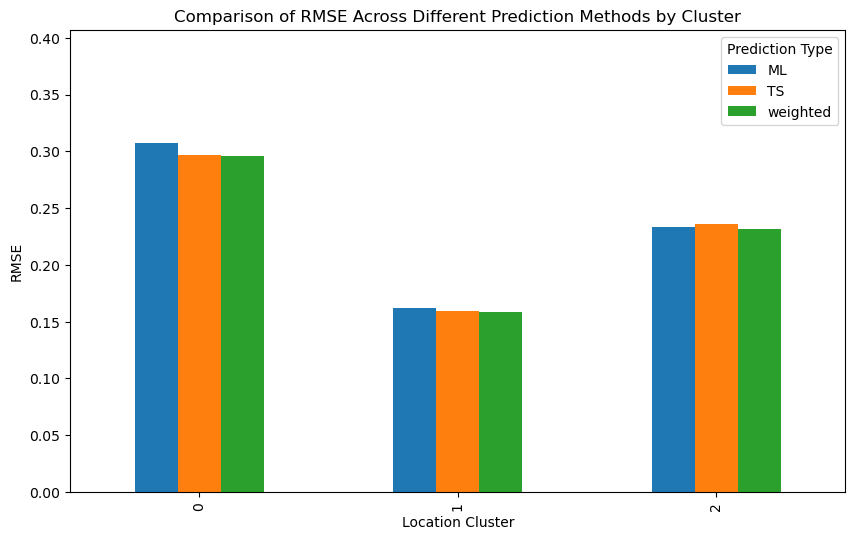

In [128]:
# Plotting
df_rmse = pd.DataFrame(rmse_data)
df_rmse.set_index('Cluster', inplace=True)
df_rmse.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of RMSE Across Different Prediction Methods by Cluster')
plt.xlabel('Location Cluster')
plt.ylabel('RMSE')
plt.ylim(0, df_rmse.max().max() + 0.1)  # Set y-limit for better visualization
plt.legend(title='Prediction Type')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23288\1421781388.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values('time', inplace=True)


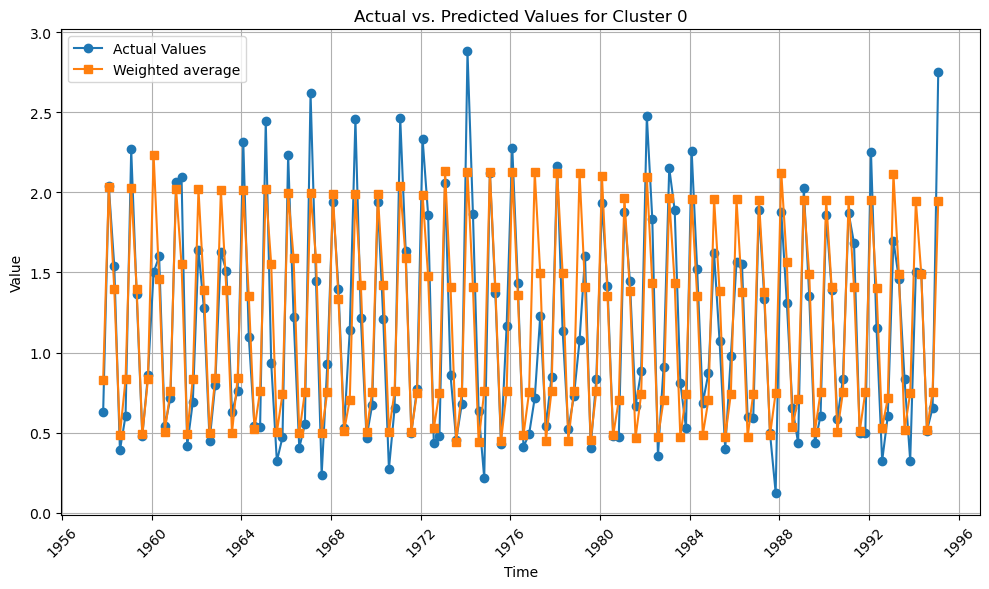

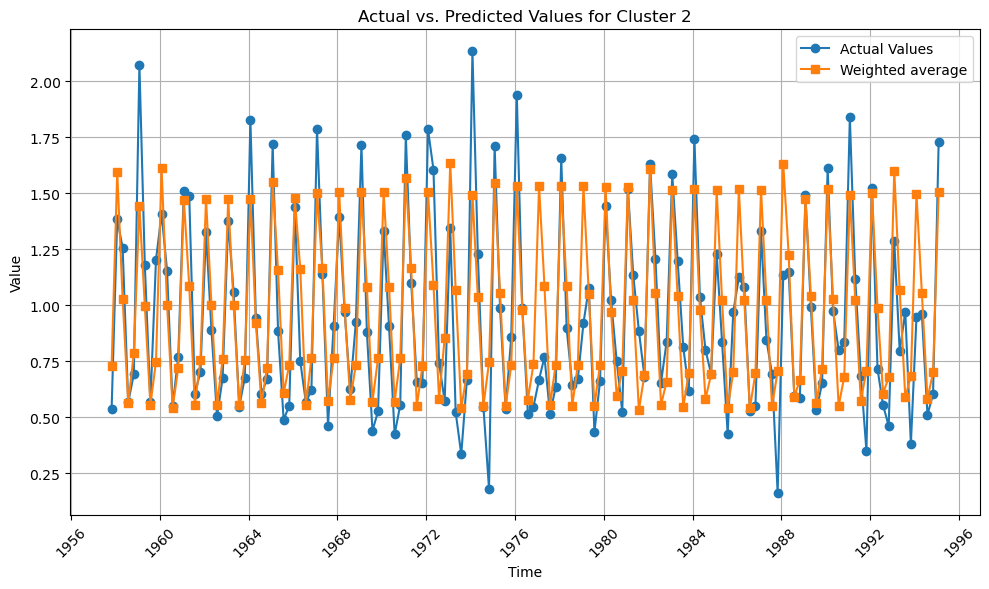

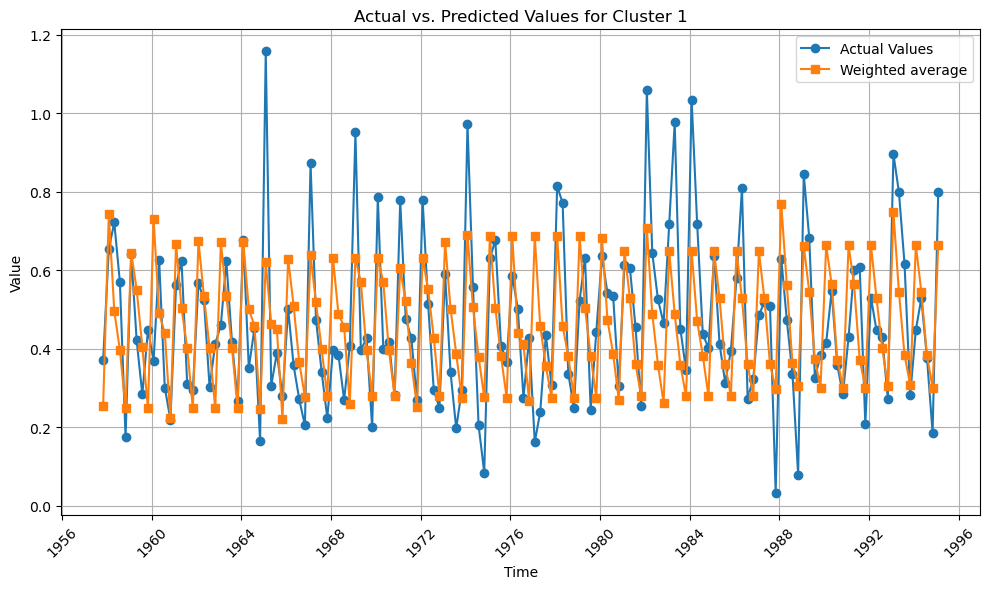

In [129]:
clusters = ensemble_df['location_cluster'].unique()
for cluster in clusters:
    # Subset the DataFrame by cluster
    subset = ensemble_df[ensemble_df['location_cluster'] == cluster]
    
    # Sorting by time to make line plots make sense
    subset.sort_values('time', inplace=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset['time'], subset['actual_values'], label='Actual Values', marker='o')
    # plt.plot(subset['time'], subset['predicted_values'], label='ML Predictions', marker='x')
    # plt.plot(subset['time'], subset['ts_forecast'], label='Time Series Forecast', marker='^')
    plt.plot(subset['time'], subset['weighted_average_forecast'], label='Weighted average', marker='s')
    
    plt.title(f'Actual vs. Predicted Values for Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Model Stacking

In [130]:
from sklearn.linear_model import LinearRegression

# Prepare the new training set from the forecasts
X_ensemble = ensemble_df[['predicted_values', 'ts_forecast']]
y_ensemble = ensemble_df['actual_values']

# Train a new model to learn how to combine the forecasts
model = LinearRegression()
model.fit(X_ensemble, y_ensemble)

# Use the trained model to make the ensemble prediction
ensemble_df['Stacked_forecast'] = model.predict(X_ensemble)

In [131]:
rmse = mean_squared_error(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'], squared=False)
mae = mean_absolute_error(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'])
r2 = r2_score(ensemble_df['actual_values'], ensemble_df['Stacked_forecast'])

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")


RMSE: 0.2347, MAE: 0.1675, R-squared: 0.8225


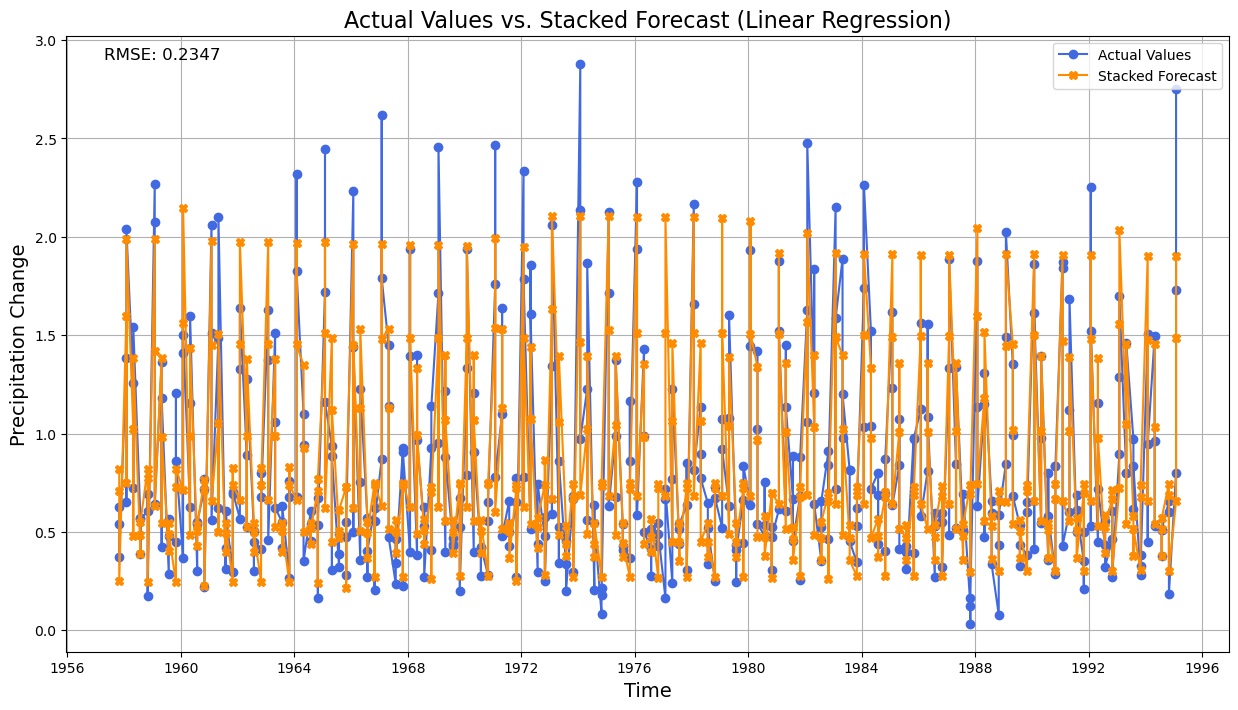

In [132]:
plt.figure(figsize=(15, 8))

# Plotting actual values
plt.plot(ensemble_df['time'], ensemble_df['actual_values'], label='Actual Values', 
         marker='o', color='royalblue')

# Plotting stacked forecast
plt.plot(ensemble_df['time'], ensemble_df['Stacked_forecast'], label='Stacked Forecast', 
         marker='X', linestyle='-', color='darkorange')

# Adding title and labels
plt.title('Actual Values vs. Stacked Forecast (Linear Regression)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Precipitation Change', fontsize=14)

# Adding RMSE to the plot
plt.figtext(0.15, 0.85, f'RMSE: {rmse:.4f}', fontsize=12, ha='left', color='Black')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
window_size = 7

# Exponential Moving Average
ensemble_df['EMA_actual'] = ensemble_df['actual_values'].ewm(span=window_size, adjust=False).mean()
ensemble_df['EMA_forecast'] = ensemble_df['Stacked_forecast'].ewm(span=window_size, adjust=False).mean()

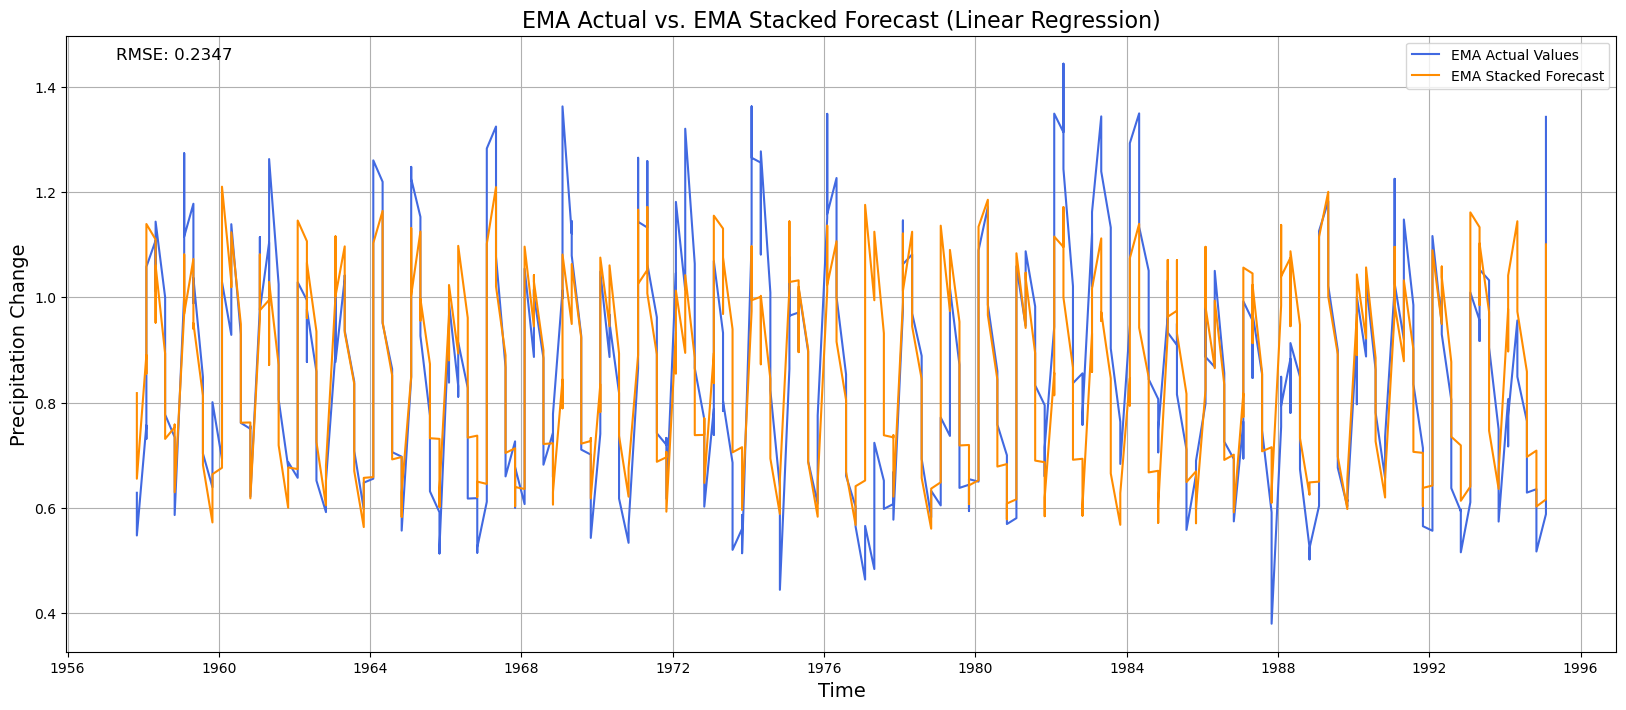

In [134]:
# Plotting with fewer markers
plt.figure(figsize=(20, 8))
plt.plot(ensemble_df['time'], ensemble_df['EMA_actual'], label='EMA Actual Values', linestyle='-', color='royalblue')
plt.plot(ensemble_df['time'], ensemble_df['EMA_forecast'], label='EMA Stacked Forecast', linestyle='-', color='darkorange')

# Additional Plot settings
plt.title('EMA Actual vs. EMA Stacked Forecast (Linear Regression)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Precipitation Change', fontsize=14)
plt.figtext(0.15, 0.85, f'RMSE: {rmse:.4f}', fontsize=12, ha='left', color='black')
plt.legend()
plt.grid(True)
plt.show()